<p style="text-align:center; font-size:3.3em; color:#AD7D67; line-height:5rem; font-style:italic; font-weight:700;">
    Mission P7 : <br>
    Implémentation d'un modèle de scoring </p>
<p style="text-align:center; font-size:2.8em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    Partie IV - Réglage des hyperparamètres LightGBM avec Optuna
</p>

<h1>Sommaire<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importation-de-l'Environnement-et-des-Données" data-toc-modified-id="Importation-de-l'Environnement-et-des-Données-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importation de l'Environnement et des Données</a></span><ul class="toc-item"><li><span><a href="#Importation-des-librairies" data-toc-modified-id="Importation-des-librairies-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importation des librairies</a></span></li><li><span><a href="#Importation-des-données" data-toc-modified-id="Importation-des-données-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Importation des données</a></span></li></ul></li><li><span><a href="#Optimisation-des-hyperparamètres-avec-Optuna-du-modèle-LightGBM" data-toc-modified-id="Optimisation-des-hyperparamètres-avec-Optuna-du-modèle-LightGBM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Optimisation des hyperparamètres avec Optuna du modèle LightGBM</a></span></li><li><span><a href="#Performance-du-modèle" data-toc-modified-id="Performance-du-modèle-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance du modèle</a></span></li></ul></div>

Généralement, les hyperparamètres des modèles arborescents peuvent être regroupés en 4 catégories :

- Paramètres qui affectent la structure et l'apprentissage des arbres de décision
- Paramètres qui affectent la vitesse d'entraînement
- Paramètres pour une meilleure précision
- Paramètres pour lutter contre le surajustement

La plupart du temps, ces catégories se chevauchent beaucoup, et l'augmentation de l'efficacité dans l'une peut entraîner une diminution dans l'autre. C'est pourquoi les régler manuellement est une erreur et doit être évité.

Des frameworks comme Optuna peuvent automatiquement trouver le « juste milieu » entre ces catégories si on leur donne une grille de paramètres suffisamment bonne.


<p style="text-align:left; font-size:2em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    Hyperparamètres contrôlant l'arborescence
</p>

Dans LGBM, le paramètre le plus important pour contrôler l'arborescence est `num_leaves`. Comme son nom l'indique, il contrôle le nombre de feuilles de décision dans un seul arbre. La feuille de décision d'un arbre est le nœud où la « décision réelle » se produit.

Le suivant est `max_depth`. Plus max_depth est grand, plus l'arbre a de niveaux, ce qui le rend plus complexe et sujet au surajustement. Trop bas, et le modèle sera sous-ajusté. Même si cela semble difficile, c'est le paramètre le plus facile à régler - une valeur entre 3 et 12 a tendance à bien fonctionner sur Kaggle pour n'importe quel ensemble de données.

Le réglage `num_leaves` peut également être facile une fois que max_depth est déterminé. Il existe une formule simple donnée dans la documentation LGBM - la limite maximale à num_leaves devrait être 2^(max_depth). Cela signifie que la valeur optimale pour num_leavesse situe dans la plage (2^3, 2^12) ou (8, 4096).

Cependant, num_leaves impacte l'apprentissage en LGBM plus que max_depth. Cela signifie qu'on doit spécifier une plage de recherche plus conservatrice comme (20, 3000).

Un autre paramètre structurel important pour un arbre est `min_data_in_leaf`. Son ampleur est également corrélée au fait que le modèle soit en surentraînement ou non. En termes simples, min_data_in_leaf spécifie le nombre minimum d'observations qui correspondent aux critères de décision dans une feuille.

Par exemple, si la feuille de décision vérifie si une caractéristique est supérieure à, disons, 13 - le réglage min_data_in_leaf sur 100 signifie que nous voulons évaluer cette feuille uniquement si au moins 100 observations d'entraînement sont supérieures à 13. C'est l'essentiel en terme simple.

La valeur optimale de min_data_in_leaf dépend du nombre d'échantillons d'apprentissage et de num_leaves. Pour les ensembles de données volumineux, définissez une valeur en centaines ou en milliers.


<p style="text-align:left; font-size:2em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    Hyperparamètres pour une meilleure précision
</p>

Une stratégie courante pour obtenir une plus grande précision consiste à utiliser de nombreux arbres de décision et à réduire le taux d'apprentissage. En d'autres termes, trouvez la meilleure combinaison de `n_estimators` et `learning_rate` dans LGBM.

`n_estimators` contrôle le nombre d'arbres de décision tandis que `learning_rate` est le paramètre de taille de pas de la descente de gradient.

Des ensembles comme LGBM construisent des arbres par itérations, et chaque nouvel arbre est utilisé pour corriger les « erreurs » des arbres précédents. Cette approche est rapide et puissante, et sujette au surajustement.

C'est pourquoi les ensembles boostés par gradient ont un `learning_rate` paramètre qui contrôle la vitesse d'apprentissage. Les valeurs typiques se situent entre 0,01 et 0,3, mais il est possible d'aller au-delà, notamment vers 0.

Ainsi, la configuration parfaite pour ces 2 paramètres ( `n_estimators` et `learning_rate` ) consiste à utiliser de nombreux arbres avec un arrêt précoce et à définir une valeur faible pour `learning_rate`.

On peut également augmenter `max_bin` la valeur par défaut (255) mais là encore, au risque de sur-ajuster.


<p style="text-align:left; font-size:2em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    Plus d'hyperparamètres pour contrôler le surajustement
</p>
    
LGBM a également des paramètres de régularisation importants.

`lambda_l1` et `lambda_l2` spécifie la régularisation L1 ou L2. La valeur optimale de ces paramètres est plus difficile à régler car leur amplitude n'est pas directement corrélée au surajustement. Cependant, une bonne plage de recherche est (0, 100) pour les deux.

Ensuite, nous avons `min_gain_to_split`. Une plage de recherche conservatrice est (0, 15). Il peut être utilisé comme régularisation supplémentaire dans les grandes grilles de paramètres.

Enfin, nous avons `bagging_fraction` et `feature_fraction`. `bagging_fraction` prend une valeur entre (0, 1) et spécifie le pourcentage d'échantillons d'apprentissage à utiliser pour former chaque arbre. Pour utiliser ce paramètre, on doit également définir `bagging_freq` une valeur entière.

`feature_fraction` spécifie le pourcentage de fonctionnalités à échantillonner lors de la formation de chaque arbre. Ainsi, il prend également une valeur comprise entre (0, 1).


<p style="text-align:left; font-size:2em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    Création de la grille de recherche dans Optuna
</p>

Optuna est un framework de réglage automatique d'hyperparamètres de nouvelle génération entièrement écrit en Python.

Ses caractéristiques les plus marquantes sont :

- la possibilité de définir des espaces de recherche Pythonic à l'aide de boucles et de conditions.
- API indépendante de la plate-forme - vous pouvez régler les estimateurs de presque tous les packages/frameworks ML, DL, y compris Sklearn, PyTorch, TensorFlow, Keras, XGBoost, LightGBM, CatBoost, etc.
- une large suite d'algorithmes d'optimisation avec des fonctionnalités d'arrêt et d'élagage précoces intégrées.
- Parallélisation facile avec peu ou pas de modifications du code.
- Prise en charge intégrée pour l'exploration visuelle des résultats de recherche.

Le processus d'optimisation dans Optuna nécessite une fonction appelée objectif qui :

- inclut la grille de paramètres pour effectuer une recherche sous forme de dictionnaire
- crée un modèle pour essayer des ensembles de combinaisons d'hyperparamètres
- adapte le modèle aux données avec un seul ensemble de candidats
- génère des prédictions à l'aide de ce modèle
- note les prédictions en fonction de métriques définies par l'utilisateur et les renvoie


Avec Optima, Nous pouvons reprendre l'optimisation même après qu'elle soit terminée si nous ne sommes pas satisfaits des résultats !
C'est un net avantage par rapport à d'autres outils similaires car une fois la recherche effectuée, ils oublient complètement l'historique des essais précédents. Optuna ne le fait pas !
Pour continuer la recherche, appelez optimize à nouveau avec les paramètres souhaités.

Dans Optuna, l'ensemble du processus d'optimisation s'appelle une étude : study = `optuna.create_study()`
Une étude a besoin d'une fonction qu'elle peut optimiser. Typiquement, cette fonction est définie par l'utilisateur et doit être nommée `objective`.
Elle doit accepter un `optuna.Trial` objet en tant que paramètre et renvoyer la métrique que nous voulons optimiser.

Si la métrique que nous voulons optimiser est un score de performance en points comme le ROC AUC ou la précision, nous définissons la direction sur `maximize`. Sinon, nous minimisons une fonction de perte telle que RMSE, RMSLE, perte de journal, etc. en définissant la direction sur `minimize`.


# Importation de l'Environnement et des Données

## Importation des librairies

In [1]:
import sys
from yellowbrick.classifier import (
    ClassificationReport,
    ConfusionMatrix,
    DiscriminationThreshold,
    ROCAUC,
    PrecisionRecallCurve,
)
import yellowbrick
from optuna import Trial, visualization
import optuna
from lightgbm import LGBMClassifier
import lightgbm as lgbm
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    make_scorer,
    precision_recall_fscore_support,
    log_loss,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    cross_val_score,
    GridSearchCV,
    RepeatedStratifiedKFold,
    train_test_split,
)
import sklearn
import warnings
import pandas as pd
import numpy as np
import scipy.stats as stats
import time

# Visualisation
import seaborn as sns
from xplotter.insights import *
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = 6, 4

sns.set_style("ticks")
sns.color_palette("pink", as_cmap=True)

# Modélisation


# pour ne pas imprimer les nombres en format scientifique
# et pour imprimer les float avec une précision de 2

#pd.set_option('display.max_columns', 25)
#pd.set_option('display.max_rows', 200)
#pd.set_option('display.max_colwidth', 30)
pd.set_option('display.float_format', '{:,.2f}'.format)

# pour ne pas imprimer les warnings
warnings.filterwarnings('ignore')

# version des librairies utilisées
print("python version", sys.version)
print("pandas version :", pd.__version__)
print("numpy version :", np.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version :", sns.__version__)
print("sklearn version :", sklearn.__version__)
print("lightgbm version :", lgbm.__version__)
print("optuna version :", optuna.__version__)
print("yellowbrick version :", yellowbrick.__version__)

python version 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:50:36) [MSC v.1929 64 bit (AMD64)]
pandas version : 1.5.0
numpy version : 1.21.5
matplotlib version : 3.6.2
seaborn version : 0.12.0
sklearn version : 1.1.2
lightgbm version : 3.3.3
optuna version : 2.10.1
yellowbrick version : 1.5


## Importation des données

Nous n'avons pas besoin de standardiser les variables car dans les modèles arborescents, l'échelle des caractéristiques n'a pas d'importance. En effet, à chaque niveau d'arborescence, le score d'une division possible sera égal, que l'entité respective ait été mise à l'échelle ou non. La mise à l'échelle est effectuée pour normaliser les données afin que la priorité ne soit pas donnée à une fonctionnalité particulière. Le rôle de la mise à l'échelle est principalement important dans les algorithmes basés sur la distance et nécessitant une distance euclidienne. 

In [2]:
# Les données totales flitrées et analysées
X = pd.read_csv('./Data/datasets_intermediaires/X_train.csv')
X.drop(labels='sk_id_curr', axis=1, inplace=True)

y = pd.read_csv('./Data/datasets_intermediaires/y.csv')

X.shape, y.shape

((307511, 56), (307511, 1))

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 56 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   region_rating_client                                307511 non-null  int64  
 1   ext_source_2                                        307511 non-null  float64
 2   taille_famille                                      307511 non-null  int64  
 3   age_client                                          307511 non-null  int64  
 4   anciennete_entreprise                               307511 non-null  int64  
 5   anciennete_cni                                      307511 non-null  int64  
 6   anciennete_portable                                 307511 non-null  int64  
 7   year_registration                                   307511 non-null  int64  
 8   heure_demande_pret                                  307511 non-n

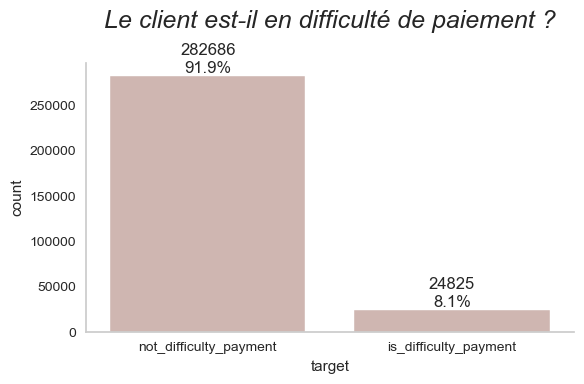

In [4]:
from xplotter.insights import *

colors = ['#d4b3ac']

loan_map = {1 : "is_difficulty_payment",
            0 : "not_difficulty_payment"}

fig, ax = plt.subplots(figsize=(6, 4))

plot_countplot(df=y, 
               col='target', 
               label_names=loan_map,
               order=True,
               palette=colors, ax=ax, orient='v', size_labels=12)

plt.title("Le client est-il en difficulté de paiement ?\n",
           loc="center", fontsize=18, fontstyle='italic')
plt.tight_layout()
plt.show()

# Optimisation des hyperparamètres avec Optuna du modèle LightGBM

In [5]:
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    
    param_grid = {
        "objective": "binary",
        "class_weight": "balanced",
        "verbose": -1,
        "boosting_type": "gbdt",
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-7, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12, step=2),
        "num_leaves": trial.suggest_int("num_leaves", 3, 12, step=2),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.8 , step=1),
    }

 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

    cv_scores = np.empty(5)
    
    for idx, (train_index, test_index) in enumerate(cv.split(X, y)):
               
        X_train, X_test = X.take(list(train_index),axis=0), X.take(list(test_index),axis=0)
        y_train, y_test = y.take(list(train_index),axis=0), y.take(list(test_index),axis=0)
    
        model = lgbm.LGBMClassifier(**param_grid, n_jobs=-2, random_state=101)
        
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[LightGBMPruningCallback(trial, "binary_logloss")])  # Add a pruning callback
        
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)
                
    return np.mean(cv_scores)
    

In [6]:
%%time

# Create study that minimizes
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")

func = lambda trial: objective(trial, X, y)

study.optimize(func, n_trials=300)

[I 2022-11-22 00:06:55,809] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] feature_fraction is set=0.9360257737830521, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9360257737830521
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=11.915705742005121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.915705742005121
[LightGBM] [Warning] bagging_fraction is set=0.4215533322628647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4215533322628647
[LightGBM] [Warning] lambda_l1 is set=1.331992455220449e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.331992455220449e-07
[LightGBM] [Warning] lambda_l2 is set=8.687805054753998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.687805054753998
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:07:09,483] Trial 0 finished with value: 0.5943757830935336 and parameters: {'n_estimators': 250, 'learning_rate': 0.0551756435207651, 'max_depth': 9, 'num_leaves': 7, 'min_data_in_leaf': 5300, 'min_child_samples': 88, 'lambda_l1': 1.331992455220449e-07, 'lambda_l2': 8.687805054753998, 'min_gain_to_split': 11.915705742005121, 'feature_fraction': 0.9360257737830521, 'bagging_fraction': 0.4215533322628647, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 0 with value: 0.5943757830935336.


[LightGBM] [Warning] feature_fraction is set=0.41467541758797954, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.41467541758797954
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=5.869999841801144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.869999841801144
[LightGBM] [Warning] bagging_fraction is set=0.6661540828614549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6661540828614549
[LightGBM] [Warning] lambda_l1 is set=0.0010935387178263578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010935387178263578
[LightGBM] [Warning] lambda_l2 is set=4.8009453078392375e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8009453078392375e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_f

[I 2022-11-22 00:07:31,522] Trial 1 finished with value: 0.6622871626535246 and parameters: {'n_estimators': 250, 'learning_rate': 0.002922198824672816, 'max_depth': 11, 'num_leaves': 7, 'min_data_in_leaf': 6100, 'min_child_samples': 78, 'lambda_l1': 0.0010935387178263578, 'lambda_l2': 4.8009453078392375e-08, 'min_gain_to_split': 5.869999841801144, 'feature_fraction': 0.41467541758797954, 'bagging_fraction': 0.6661540828614549, 'bagging_freq': 1, 'colsample_bytree': 0.3}. Best is trial 0 with value: 0.5943757830935336.


[LightGBM] [Warning] feature_fraction is set=0.9566663669834489, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9566663669834489
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=12.797346320343738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.797346320343738
[LightGBM] [Warning] bagging_fraction is set=0.7521828917891743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7521828917891743
[LightGBM] [Warning] lambda_l1 is set=0.0029866111732422917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029866111732422917
[LightGBM] [Warning] lambda_l2 is set=1.248912487127925e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.248912487127925e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fra

[I 2022-11-22 00:07:54,081] Trial 2 finished with value: 0.6775290634030481 and parameters: {'n_estimators': 250, 'learning_rate': 0.0008292964569201049, 'max_depth': 9, 'num_leaves': 11, 'min_data_in_leaf': 7800, 'min_child_samples': 53, 'lambda_l1': 0.0029866111732422917, 'lambda_l2': 1.248912487127925e-06, 'min_gain_to_split': 12.797346320343738, 'feature_fraction': 0.9566663669834489, 'bagging_fraction': 0.7521828917891743, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 0 with value: 0.5943757830935336.


[LightGBM] [Warning] feature_fraction is set=0.711620685132414, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.711620685132414
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] min_gain_to_split is set=5.198411404448729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.198411404448729
[LightGBM] [Warning] bagging_fraction is set=0.8333360468539825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333360468539825
[LightGBM] [Warning] lambda_l1 is set=7.2164219009526904e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.2164219009526904e-06
[LightGBM] [Warning] lambda_l2 is set=1.421024779736183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.421024779736183
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:08:06,323] Trial 3 finished with value: 0.603190436047925 and parameters: {'n_estimators': 100, 'learning_rate': 0.09532846112143648, 'max_depth': 3, 'num_leaves': 7, 'min_data_in_leaf': 8300, 'min_child_samples': 80, 'lambda_l1': 7.2164219009526904e-06, 'lambda_l2': 1.421024779736183, 'min_gain_to_split': 5.198411404448729, 'feature_fraction': 0.711620685132414, 'bagging_fraction': 0.8333360468539825, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 0 with value: 0.5943757830935336.


[LightGBM] [Warning] feature_fraction is set=0.7107837662403516, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.7107837662403516
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.6488647946764963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6488647946764963
[LightGBM] [Warning] bagging_fraction is set=0.6900410814001166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6900410814001166
[LightGBM] [Warning] lambda_l1 is set=1.1070086603431163e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1070086603431163e-06
[LightGBM] [Warning] lambda_l2 is set=8.674752854058944e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.674752854058944e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_f

[I 2022-11-22 00:08:29,298] Trial 4 finished with value: 0.6896374653872889 and parameters: {'n_estimators': 350, 'learning_rate': 0.00014446418232287017, 'max_depth': 7, 'num_leaves': 7, 'min_data_in_leaf': 6600, 'min_child_samples': 94, 'lambda_l1': 1.1070086603431163e-06, 'lambda_l2': 8.674752854058944e-07, 'min_gain_to_split': 1.6488647946764963, 'feature_fraction': 0.7107837662403516, 'bagging_fraction': 0.6900410814001166, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 0 with value: 0.5943757830935336.


[LightGBM] [Warning] feature_fraction is set=0.8623688615098831, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8623688615098831
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=12.346372254940608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.346372254940608
[LightGBM] [Warning] bagging_fraction is set=0.7333326826789888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7333326826789888
[LightGBM] [Warning] lambda_l1 is set=0.00019498998965584584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019498998965584584
[LightGBM] [Warning] lambda_l2 is set=1.0210828871440583e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0210828871440583e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature

[I 2022-11-22 00:08:53,642] Trial 5 finished with value: 0.6150019779377811 and parameters: {'n_estimators': 300, 'learning_rate': 0.018560090492481467, 'max_depth': 3, 'num_leaves': 5, 'min_data_in_leaf': 7400, 'min_child_samples': 69, 'lambda_l1': 0.00019498998965584584, 'lambda_l2': 1.0210828871440583e-07, 'min_gain_to_split': 12.346372254940608, 'feature_fraction': 0.8623688615098831, 'bagging_fraction': 0.7333326826789888, 'bagging_freq': 2, 'colsample_bytree': 0.3}. Best is trial 0 with value: 0.5943757830935336.


[LightGBM] [Warning] feature_fraction is set=0.9506300497152037, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9506300497152037
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.11022038616618601, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11022038616618601
[LightGBM] [Warning] bagging_fraction is set=0.8137313436143907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8137313436143907
[LightGBM] [Warning] lambda_l1 is set=0.6521214270736071, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6521214270736071
[LightGBM] [Warning] lambda_l2 is set=0.0017176555646125063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017176555646125063
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fractio

[I 2022-11-22 00:09:04,602] Trial 6 finished with value: 0.6283907213701684 and parameters: {'n_estimators': 100, 'learning_rate': 0.021479781960832972, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 2800, 'min_child_samples': 32, 'lambda_l1': 0.6521214270736071, 'lambda_l2': 0.0017176555646125063, 'min_gain_to_split': 0.11022038616618601, 'feature_fraction': 0.9506300497152037, 'bagging_fraction': 0.8137313436143907, 'bagging_freq': 3, 'colsample_bytree': 0.3}. Best is trial 0 with value: 0.5943757830935336.


[LightGBM] [Warning] feature_fraction is set=0.9687828170825193, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9687828170825193
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=3.3072418262401366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3072418262401366
[LightGBM] [Warning] bagging_fraction is set=0.7404842460276259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7404842460276259
[LightGBM] [Warning] lambda_l1 is set=0.0005727673614850234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005727673614850234
[LightGBM] [Warning] lambda_l2 is set=1.2096556347373215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2096556347373215
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:09:05,541] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:09:06,343] Trial 8 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9645759401023666, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9645759401023666
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.055072696392987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.055072696392987
[LightGBM] [Warning] bagging_fraction is set=0.675111555963283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.675111555963283
[LightGBM] [Warning] lambda_l1 is set=0.0012753993324366103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012753993324366103
[LightGBM] [Warning] lambda_l2 is set=0.029575930215560757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029575930215560757
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fractio

[I 2022-11-22 00:09:28,453] Trial 9 finished with value: 0.600733704304915 and parameters: {'n_estimators': 350, 'learning_rate': 0.02965509316354065, 'max_depth': 3, 'num_leaves': 11, 'min_data_in_leaf': 6700, 'min_child_samples': 22, 'lambda_l1': 0.0012753993324366103, 'lambda_l2': 0.029575930215560757, 'min_gain_to_split': 11.055072696392987, 'feature_fraction': 0.9645759401023666, 'bagging_fraction': 0.675111555963283, 'bagging_freq': 1, 'colsample_bytree': 0.3}. Best is trial 0 with value: 0.5943757830935336.


[LightGBM] [Warning] feature_fraction is set=0.8067932135243223, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8067932135243223
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=9.798570731643546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.798570731643546
[LightGBM] [Warning] bagging_fraction is set=0.40267872302918417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40267872302918417
[LightGBM] [Warning] lambda_l1 is set=1.063189015197714e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.063189015197714e-08
[LightGBM] [Warning] lambda_l2 is set=0.00016102770292536557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016102770292536557
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-22 00:09:29,606] Trial 10 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.8331548118063201, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8331548118063201
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=14.985431776250833, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.985431776250833
[LightGBM] [Warning] bagging_fraction is set=0.991543457028149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.991543457028149
[LightGBM] [Warning] lambda_l1 is set=2.6178578456812224e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6178578456812224e-08
[LightGBM] [Warning] lambda_l2 is set=0.034335973781262026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034335973781262026
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fracti

[I 2022-11-22 00:09:45,451] Trial 11 finished with value: 0.5926005260417755 and parameters: {'n_estimators': 400, 'learning_rate': 0.2260938028212066, 'max_depth': 5, 'num_leaves': 9, 'min_data_in_leaf': 4600, 'min_child_samples': 6, 'lambda_l1': 2.6178578456812224e-08, 'lambda_l2': 0.034335973781262026, 'min_gain_to_split': 14.985431776250833, 'feature_fraction': 0.8331548118063201, 'bagging_fraction': 0.991543457028149, 'bagging_freq': 4, 'colsample_bytree': 0.3}. Best is trial 11 with value: 0.5926005260417755.


[LightGBM] [Warning] feature_fraction is set=0.8200141724869751, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8200141724869751
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] min_gain_to_split is set=14.953979333494377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.953979333494377
[LightGBM] [Warning] bagging_fraction is set=0.9935235156519089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9935235156519089
[LightGBM] [Warning] lambda_l1 is set=1.1575186860651062e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1575186860651062e-08
[LightGBM] [Warning] lambda_l2 is set=5.4888556672271145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.4888556672271145
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fractio

[I 2022-11-22 00:09:56,759] Trial 12 finished with value: 0.5921133771015908 and parameters: {'n_estimators': 450, 'learning_rate': 0.19696696619535553, 'max_depth': 5, 'num_leaves': 9, 'min_data_in_leaf': 4300, 'min_child_samples': 11, 'lambda_l1': 1.1575186860651062e-08, 'lambda_l2': 5.4888556672271145, 'min_gain_to_split': 14.953979333494377, 'feature_fraction': 0.8200141724869751, 'bagging_fraction': 0.9935235156519089, 'bagging_freq': 4, 'colsample_bytree': 0.3}. Best is trial 12 with value: 0.5921133771015908.


[LightGBM] [Warning] feature_fraction is set=0.7962035972223126, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.7962035972223126
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=14.923749536626444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.923749536626444
[LightGBM] [Warning] bagging_fraction is set=0.9704048957726835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9704048957726835
[LightGBM] [Warning] lambda_l1 is set=1.170765109197591e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.170765109197591e-08
[LightGBM] [Warning] lambda_l2 is set=0.04757435052719933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04757435052719933
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction i

[I 2022-11-22 00:10:10,256] Trial 13 finished with value: 0.5906540808293127 and parameters: {'n_estimators': 500, 'learning_rate': 0.17035994118263753, 'max_depth': 5, 'num_leaves': 9, 'min_data_in_leaf': 900, 'min_child_samples': 5, 'lambda_l1': 1.170765109197591e-08, 'lambda_l2': 0.04757435052719933, 'min_gain_to_split': 14.923749536626444, 'feature_fraction': 0.7962035972223126, 'bagging_fraction': 0.9704048957726835, 'bagging_freq': 4, 'colsample_bytree': 0.3}. Best is trial 13 with value: 0.5906540808293127.


[LightGBM] [Warning] feature_fraction is set=0.6313206930645097, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.6313206930645097
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.955529692759459, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.955529692759459
[LightGBM] [Warning] bagging_fraction is set=0.9971351725651476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9971351725651476
[LightGBM] [Warning] lambda_l1 is set=3.10894753067719e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.10894753067719e-06
[LightGBM] [Warning] lambda_l2 is set=0.050646520074408063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.050646520074408063
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2022-11-22 00:10:11,023] Trial 14 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.7642808504395626, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.7642808504395626
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.125179774907112, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.125179774907112
[LightGBM] [Warning] bagging_fraction is set=0.9058632476699309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9058632476699309
[LightGBM] [Warning] lambda_l1 is set=2.7643860456518906e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7643860456518906e-07
[LightGBM] [Warning] lambda_l2 is set=0.00046828718790811773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00046828718790811773
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fra

[I 2022-11-22 00:10:27,131] Trial 15 finished with value: 0.5888633683485758 and parameters: {'n_estimators': 450, 'learning_rate': 0.2894518035156203, 'max_depth': 5, 'num_leaves': 5, 'min_data_in_leaf': 400, 'min_child_samples': 22, 'lambda_l1': 2.7643860456518906e-07, 'lambda_l2': 0.00046828718790811773, 'min_gain_to_split': 8.125179774907112, 'feature_fraction': 0.7642808504395626, 'bagging_fraction': 0.9058632476699309, 'bagging_freq': 5, 'colsample_bytree': 0.3}. Best is trial 15 with value: 0.5888633683485758.


[LightGBM] [Warning] feature_fraction is set=0.6431050366747669, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.6431050366747669
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=8.663672290411679, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.663672290411679
[LightGBM] [Warning] bagging_fraction is set=0.9022235867087286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9022235867087286
[LightGBM] [Warning] lambda_l1 is set=3.5651510501568133e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5651510501568133e-07
[LightGBM] [Warning] lambda_l2 is set=7.451666278402474e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.451666278402474e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-22 00:10:28,961] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:10:30,162] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:10:31,401] Trial 18 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.7682850291614067, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.7682850291614067
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=4.478895628631994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.478895628631994
[LightGBM] [Warning] bagging_fraction is set=0.5966063561744714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5966063561744714
[LightGBM] [Warning] lambda_l1 is set=1.1189196457319889e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1189196457319889e-07
[LightGBM] [Warning] lambda_l2 is set=0.003358874162507001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003358874162507001
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fract

[I 2022-11-22 00:10:53,466] Trial 19 finished with value: 0.5850164607858175 and parameters: {'n_estimators': 450, 'learning_rate': 0.2959559978103029, 'max_depth': 7, 'num_leaves': 5, 'min_data_in_leaf': 9200, 'min_child_samples': 17, 'lambda_l1': 1.1189196457319889e-07, 'lambda_l2': 0.003358874162507001, 'min_gain_to_split': 4.478895628631994, 'feature_fraction': 0.7682850291614067, 'bagging_fraction': 0.5966063561744714, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 19 with value: 0.5850164607858175.


[LightGBM] [Warning] feature_fraction is set=0.759575781675427, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.759575781675427
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=3.874521249517249, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.874521249517249
[LightGBM] [Warning] bagging_fraction is set=0.5964971589359115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5964971589359115
[LightGBM] [Warning] lambda_l1 is set=3.8521991906879644e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8521991906879644e-05
[LightGBM] [Warning] lambda_l2 is set=0.0023299776663366196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023299776663366196
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:10:54,696] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:10:57,418] Trial 21 pruned. Trial was pruned at iteration 350.
[I 2022-11-22 00:10:58,185] Trial 22 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:10:59,005] Trial 23 pruned. Trial was pruned at iteration 2.
[I 2022-11-22 00:10:59,855] Trial 24 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.8748917533190159, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8748917533190159
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=6.594720126535518, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.594720126535518
[LightGBM] [Warning] bagging_fraction is set=0.9409862232454326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9409862232454326
[LightGBM] [Warning] lambda_l1 is set=3.7912532255450543e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7912532255450543e-06
[LightGBM] [Warning] lambda_l2 is set=0.0006048984169298619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006048984169298619
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fra

[I 2022-11-22 00:11:13,048] Trial 25 finished with value: 0.5887262184297539 and parameters: {'n_estimators': 400, 'learning_rate': 0.27158059581322624, 'max_depth': 9, 'num_leaves': 7, 'min_data_in_leaf': 3500, 'min_child_samples': 63, 'lambda_l1': 3.7912532255450543e-06, 'lambda_l2': 0.0006048984169298619, 'min_gain_to_split': 6.594720126535518, 'feature_fraction': 0.8748917533190159, 'bagging_fraction': 0.9409862232454326, 'bagging_freq': 5, 'colsample_bytree': 0.3}. Best is trial 19 with value: 0.5850164607858175.


[LightGBM] [Warning] feature_fraction is set=0.9087341398281146, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9087341398281146
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=6.695226280587091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.695226280587091
[LightGBM] [Warning] bagging_fraction is set=0.9398574185096255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9398574185096255
[LightGBM] [Warning] lambda_l1 is set=4.052482395533058e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.052482395533058e-06
[LightGBM] [Warning] lambda_l2 is set=0.0004608861284432943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004608861284432943
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fract

[I 2022-11-22 00:11:24,808] Trial 26 finished with value: 0.5891654218429303 and parameters: {'n_estimators': 400, 'learning_rate': 0.29781962255784866, 'max_depth': 9, 'num_leaves': 7, 'min_data_in_leaf': 3300, 'min_child_samples': 62, 'lambda_l1': 4.052482395533058e-06, 'lambda_l2': 0.0004608861284432943, 'min_gain_to_split': 6.695226280587091, 'feature_fraction': 0.9087341398281146, 'bagging_fraction': 0.9398574185096255, 'bagging_freq': 5, 'colsample_bytree': 0.3}. Best is trial 19 with value: 0.5850164607858175.


[LightGBM] [Warning] feature_fraction is set=0.8522437341576274, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8522437341576274
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=4.528269785661528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.528269785661528
[LightGBM] [Warning] bagging_fraction is set=0.8626979944060498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8626979944060498
[LightGBM] [Warning] lambda_l1 is set=6.558414618110097e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.558414618110097e-05
[LightGBM] [Warning] lambda_l2 is set=0.00040071916678152556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040071916678152556
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:11:26,191] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:11:27,325] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:11:28,280] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:11:29,390] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:11:30,825] Trial 31 pruned. Trial was pruned at iteration 2.


[LightGBM] [Warning] feature_fraction is set=0.8756670829367553, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8756670829367553
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=8.031976342289276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.031976342289276
[LightGBM] [Warning] bagging_fraction is set=0.8668019013388857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8668019013388857
[LightGBM] [Warning] lambda_l1 is set=8.211520762422993e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.211520762422993e-06
[LightGBM] [Warning] lambda_l2 is set=0.000634995141467672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000634995141467672
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fractio

[I 2022-11-22 00:11:42,483] Trial 32 finished with value: 0.5893373899965599 and parameters: {'n_estimators': 400, 'learning_rate': 0.28578970620378963, 'max_depth': 11, 'num_leaves': 7, 'min_data_in_leaf': 3300, 'min_child_samples': 84, 'lambda_l1': 8.211520762422993e-06, 'lambda_l2': 0.000634995141467672, 'min_gain_to_split': 8.031976342289276, 'feature_fraction': 0.8756670829367553, 'bagging_fraction': 0.8668019013388857, 'bagging_freq': 5, 'colsample_bytree': 0.3}. Best is trial 19 with value: 0.5850164607858175.


[LightGBM] [Warning] feature_fraction is set=0.9131210446492477, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9131210446492477
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=4.992735290795633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.992735290795633
[LightGBM] [Warning] bagging_fraction is set=0.9454250908981419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9454250908981419
[LightGBM] [Warning] lambda_l1 is set=4.914765659768133e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.914765659768133e-07
[LightGBM] [Warning] lambda_l2 is set=0.0039406361277507344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0039406361277507344
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:11:43,796] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:11:44,629] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:11:45,549] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:11:47,015] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:11:47,863] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:11:48,687] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:11:49,569] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:11:50,405] Trial 40 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.8677445777837022, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8677445777837022
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=8.026330055447367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.026330055447367
[LightGBM] [Warning] bagging_fraction is set=0.7795494001655588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7795494001655588
[LightGBM] [Warning] lambda_l1 is set=7.892952710701936e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.892952710701936e-06
[LightGBM] [Warning] lambda_l2 is set=0.0007792345101112945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007792345101112945
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fract

[I 2022-11-22 00:12:06,631] Trial 41 finished with value: 0.5864653224223834 and parameters: {'n_estimators': 400, 'learning_rate': 0.14871859695368211, 'max_depth': 11, 'num_leaves': 7, 'min_data_in_leaf': 1700, 'min_child_samples': 82, 'lambda_l1': 7.892952710701936e-06, 'lambda_l2': 0.0007792345101112945, 'min_gain_to_split': 8.026330055447367, 'feature_fraction': 0.8677445777837022, 'bagging_fraction': 0.7795494001655588, 'bagging_freq': 5, 'colsample_bytree': 0.3}. Best is trial 19 with value: 0.5850164607858175.


[LightGBM] [Warning] feature_fraction is set=0.8466182476282047, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8466182476282047
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=9.829596592446435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.829596592446435
[LightGBM] [Warning] bagging_fraction is set=0.7736661927862425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7736661927862425
[LightGBM] [Warning] lambda_l1 is set=6.680664327884323e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.680664327884323e-07
[LightGBM] [Warning] lambda_l2 is set=0.0012036368972555883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012036368972555883
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-22 00:12:07,966] Trial 42 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:12:08,801] Trial 43 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:12:09,640] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:12:10,481] Trial 45 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9937654639909853, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9937654639909853
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=9.208950085883917, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.208950085883917
[LightGBM] [Warning] bagging_fraction is set=0.6601012227077905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6601012227077905
[LightGBM] [Warning] lambda_l1 is set=1.4361697357088132e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4361697357088132e-05
[LightGBM] [Warning] lambda_l2 is set=0.0008402160621166635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008402160621166635
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fra

[I 2022-11-22 00:12:23,755] Trial 46 finished with value: 0.5889996650105351 and parameters: {'n_estimators': 400, 'learning_rate': 0.15836146798262318, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 7000, 'min_child_samples': 53, 'lambda_l1': 1.4361697357088132e-05, 'lambda_l2': 0.0008402160621166635, 'min_gain_to_split': 9.208950085883917, 'feature_fraction': 0.9937654639909853, 'bagging_fraction': 0.6601012227077905, 'bagging_freq': 4, 'colsample_bytree': 0.3}. Best is trial 19 with value: 0.5850164607858175.


[LightGBM] [Warning] feature_fraction is set=0.9884047892011243, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9884047892011243
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=11.31962374795059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.31962374795059
[LightGBM] [Warning] bagging_fraction is set=0.6344443078440535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6344443078440535
[LightGBM] [Warning] lambda_l1 is set=1.3927786642746402e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3927786642746402e-05
[LightGBM] [Warning] lambda_l2 is set=0.002552950508373137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002552950508373137
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2022-11-22 00:12:24,576] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:12:25,399] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:12:26,235] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:12:27,080] Trial 50 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.8919780695929082, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8919780695929082
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=9.010609199912485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.010609199912485
[LightGBM] [Warning] bagging_fraction is set=0.8873346980085166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8873346980085166
[LightGBM] [Warning] lambda_l1 is set=3.0944216187063537e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0944216187063537e-06
[LightGBM] [Warning] lambda_l2 is set=0.0010083541745220122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010083541745220122
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fra

[I 2022-11-22 00:12:41,443] Trial 51 finished with value: 0.5888962271196811 and parameters: {'n_estimators': 400, 'learning_rate': 0.18386137231866986, 'max_depth': 11, 'num_leaves': 7, 'min_data_in_leaf': 2200, 'min_child_samples': 64, 'lambda_l1': 3.0944216187063537e-06, 'lambda_l2': 0.0010083541745220122, 'min_gain_to_split': 9.010609199912485, 'feature_fraction': 0.8919780695929082, 'bagging_fraction': 0.8873346980085166, 'bagging_freq': 5, 'colsample_bytree': 0.3}. Best is trial 19 with value: 0.5850164607858175.


[LightGBM] [Warning] feature_fraction is set=0.8219894884349385, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.8219894884349385
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=9.171202848767404, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.171202848767404
[LightGBM] [Warning] bagging_fraction is set=0.8876186493382137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8876186493382137
[LightGBM] [Warning] lambda_l1 is set=3.8414385213436075e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8414385213436075e-07
[LightGBM] [Warning] lambda_l2 is set=0.0012922876654608074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012922876654608074
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-22 00:12:42,302] Trial 52 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:12:43,164] Trial 53 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:12:44,286] Trial 54 pruned. Trial was pruned at iteration 16.
[I 2022-11-22 00:12:45,172] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:12:46,030] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:12:46,924] Trial 57 pruned. Trial was pruned at iteration 1.
[I 2022-11-22 00:12:47,762] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:12:48,702] Trial 59 pruned. Trial was pruned at iteration 4.
[I 2022-11-22 00:12:49,580] Trial 60 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:12:50,533] Trial 61 pruned. Trial was pruned at iteration 9.
[I 2022-11-22 00:12:51,444] Trial 62 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9558424884956402, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9558424884956402
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=7.071877259302858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.071877259302858
[LightGBM] [Warning] bagging_fraction is set=0.8884600539759572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8884600539759572
[LightGBM] [Warning] lambda_l1 is set=2.8147219876791094e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8147219876791094e-05
[LightGBM] [Warning] lambda_l2 is set=0.00032701645052517144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00032701645052517144
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_f

[I 2022-11-22 00:13:06,015] Trial 63 finished with value: 0.5854137477920588 and parameters: {'n_estimators': 400, 'learning_rate': 0.2053429371233342, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 1300, 'min_child_samples': 67, 'lambda_l1': 2.8147219876791094e-05, 'lambda_l2': 0.00032701645052517144, 'min_gain_to_split': 7.071877259302858, 'feature_fraction': 0.9558424884956402, 'bagging_fraction': 0.8884600539759572, 'bagging_freq': 5, 'colsample_bytree': 0.3}. Best is trial 19 with value: 0.5850164607858175.


[LightGBM] [Warning] feature_fraction is set=0.9506984244378284, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9506984244378284
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=8.494776584373508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.494776584373508
[LightGBM] [Warning] bagging_fraction is set=0.8940456267232704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8940456267232704
[LightGBM] [Warning] lambda_l1 is set=3.450915398740849e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.450915398740849e-05
[LightGBM] [Warning] lambda_l2 is set=0.0018796612242858951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018796612242858951
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fract

[I 2022-11-22 00:13:19,510] Trial 64 finished with value: 0.5861439425267491 and parameters: {'n_estimators': 450, 'learning_rate': 0.20772640471162845, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 1300, 'min_child_samples': 67, 'lambda_l1': 3.450915398740849e-05, 'lambda_l2': 0.0018796612242858951, 'min_gain_to_split': 8.494776584373508, 'feature_fraction': 0.9506984244378284, 'bagging_fraction': 0.8940456267232704, 'bagging_freq': 4, 'colsample_bytree': 0.3}. Best is trial 19 with value: 0.5850164607858175.


[LightGBM] [Warning] feature_fraction is set=0.9543008865214723, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9543008865214723
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=7.1034709350158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.1034709350158
[LightGBM] [Warning] bagging_fraction is set=0.8934044813716641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8934044813716641
[LightGBM] [Warning] lambda_l1 is set=5.2631710128569044e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2631710128569044e-05
[LightGBM] [Warning] lambda_l2 is set=0.002434264875350806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002434264875350806
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2022-11-22 00:13:20,304] Trial 65 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:13:21,223] Trial 66 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9221689154826762, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9221689154826762
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=5.563627241808593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.563627241808593
[LightGBM] [Warning] bagging_fraction is set=0.8168858656466477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8168858656466477
[LightGBM] [Warning] lambda_l1 is set=0.004233790489690113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004233790489690113
[LightGBM] [Warning] lambda_l2 is set=0.019956206462183105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019956206462183105
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction 

[I 2022-11-22 00:13:36,497] Trial 67 finished with value: 0.5818120552040741 and parameters: {'n_estimators': 450, 'learning_rate': 0.21604535264308827, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 1200, 'min_child_samples': 60, 'lambda_l1': 0.004233790489690113, 'lambda_l2': 0.019956206462183105, 'min_gain_to_split': 5.563627241808593, 'feature_fraction': 0.9221689154826762, 'bagging_fraction': 0.8168858656466477, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 67 with value: 0.5818120552040741.


[LightGBM] [Warning] feature_fraction is set=0.9212619833294899, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9212619833294899
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=5.534759385523466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.534759385523466
[LightGBM] [Warning] bagging_fraction is set=0.7982566845654614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7982566845654614
[LightGBM] [Warning] lambda_l1 is set=0.010004815538306587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010004815538306587
[LightGBM] [Warning] lambda_l2 is set=0.6592654215892683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6592654215892683
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:13:37,329] Trial 68 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9704718204621234, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9704718204621234
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.040419090582643, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.040419090582643
[LightGBM] [Warning] bagging_fraction is set=0.8489336357035585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8489336357035585
[LightGBM] [Warning] lambda_l1 is set=0.004873128720089644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004873128720089644
[LightGBM] [Warning] lambda_l2 is set=0.03654149646913754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03654149646913754
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:13:51,802] Trial 69 finished with value: 0.5819823449882545 and parameters: {'n_estimators': 450, 'learning_rate': 0.2301955552779585, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 500, 'min_child_samples': 67, 'lambda_l1': 0.004873128720089644, 'lambda_l2': 0.03654149646913754, 'min_gain_to_split': 6.040419090582643, 'feature_fraction': 0.9704718204621234, 'bagging_fraction': 0.8489336357035585, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 67 with value: 0.5818120552040741.


[LightGBM] [Warning] feature_fraction is set=0.9683518705171356, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9683518705171356
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.290451513753323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.290451513753323
[LightGBM] [Warning] bagging_fraction is set=0.8498197551726128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8498197551726128
[LightGBM] [Warning] lambda_l1 is set=0.003897411311148782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003897411311148782
[LightGBM] [Warning] lambda_l2 is set=0.06744557660573305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06744557660573305
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:13:52,615] Trial 70 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.954318433189034, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.954318433189034
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.836908648647768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.836908648647768
[LightGBM] [Warning] bagging_fraction is set=0.8131546831186582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8131546831186582
[LightGBM] [Warning] lambda_l1 is set=0.03177803293599928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03177803293599928
[LightGBM] [Warning] lambda_l2 is set=0.026425837855477145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026425837855477145
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set

[I 2022-11-22 00:14:09,963] Trial 71 finished with value: 0.5747553423862902 and parameters: {'n_estimators': 450, 'learning_rate': 0.27394826651163146, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 200, 'min_child_samples': 60, 'lambda_l1': 0.03177803293599928, 'lambda_l2': 0.026425837855477145, 'min_gain_to_split': 4.836908648647768, 'feature_fraction': 0.954318433189034, 'bagging_fraction': 0.8131546831186582, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 71 with value: 0.5747553423862902.


[LightGBM] [Warning] feature_fraction is set=0.9507738801786358, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9507738801786358
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=60 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=3.100879620163898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.100879620163898
[LightGBM] [Warning] bagging_fraction is set=0.8115143676625083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115143676625083
[LightGBM] [Warning] lambda_l1 is set=0.061875074752868915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.061875074752868915
[LightGBM] [Warning] lambda_l2 is set=0.04005798724607144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04005798724607144
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:14:36,802] Trial 72 finished with value: 0.5684502487695214 and parameters: {'n_estimators': 450, 'learning_rate': 0.20341816108978578, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 1300, 'min_child_samples': 60, 'lambda_l1': 0.061875074752868915, 'lambda_l2': 0.04005798724607144, 'min_gain_to_split': 3.100879620163898, 'feature_fraction': 0.9507738801786358, 'bagging_fraction': 0.8115143676625083, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 72 with value: 0.5684502487695214.


[LightGBM] [Warning] feature_fraction is set=0.9488624199790826, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9488624199790826
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.0228496824431845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0228496824431845
[LightGBM] [Warning] bagging_fraction is set=0.8227979868037615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8227979868037615
[LightGBM] [Warning] lambda_l1 is set=0.058564803608507965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.058564803608507965
[LightGBM] [Warning] lambda_l2 is set=0.023621419054093245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023621419054093245
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:14:37,659] Trial 73 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:14:38,537] Trial 74 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9253867774675841, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9253867774675841
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=3.796265591264363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.796265591264363
[LightGBM] [Warning] bagging_fraction is set=0.8116428693199372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8116428693199372
[LightGBM] [Warning] lambda_l1 is set=0.03675217031528435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03675217031528435
[LightGBM] [Warning] lambda_l2 is set=0.025772318223821113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025772318223821113
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:14:59,770] Trial 75 finished with value: 0.5745021952554875 and parameters: {'n_estimators': 450, 'learning_rate': 0.21696779905433242, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 1400, 'min_child_samples': 66, 'lambda_l1': 0.03675217031528435, 'lambda_l2': 0.025772318223821113, 'min_gain_to_split': 3.796265591264363, 'feature_fraction': 0.9253867774675841, 'bagging_fraction': 0.8116428693199372, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 72 with value: 0.5684502487695214.


[LightGBM] [Warning] feature_fraction is set=0.9271469328036163, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9271469328036163
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=3.7444036332755166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7444036332755166
[LightGBM] [Warning] bagging_fraction is set=0.8066771984305522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8066771984305522
[LightGBM] [Warning] lambda_l1 is set=0.03946164914396867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03946164914396867
[LightGBM] [Warning] lambda_l2 is set=0.02982447405085667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02982447405085667
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:15:22,772] Trial 76 finished with value: 0.5730440657738314 and parameters: {'n_estimators': 450, 'learning_rate': 0.2084265460220502, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 1300, 'min_child_samples': 75, 'lambda_l1': 0.03946164914396867, 'lambda_l2': 0.02982447405085667, 'min_gain_to_split': 3.7444036332755166, 'feature_fraction': 0.9271469328036163, 'bagging_fraction': 0.8066771984305522, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 72 with value: 0.5684502487695214.


[LightGBM] [Warning] feature_fraction is set=0.9850202201148994, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9850202201148994
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.0139888158253285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0139888158253285
[LightGBM] [Warning] bagging_fraction is set=0.8030144720755196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8030144720755196
[LightGBM] [Warning] lambda_l1 is set=0.036810647316926993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036810647316926993
[LightGBM] [Warning] lambda_l2 is set=0.04066584584925405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04066584584925405
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:15:23,607] Trial 77 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:15:24,976] Trial 78 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:15:25,834] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:15:26,778] Trial 80 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] feature_fraction is set=0.9491662289605584, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9491662289605584
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.661926457909116, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.661926457909116
[LightGBM] [Warning] bagging_fraction is set=0.7568634109091169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7568634109091169
[LightGBM] [Warning] lambda_l1 is set=0.003531639880379705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003531639880379705
[LightGBM] [Warning] lambda_l2 is set=0.017411423071971265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017411423071971265
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:15:52,138] Trial 81 finished with value: 0.5628537689168287 and parameters: {'n_estimators': 450, 'learning_rate': 0.21760790896537022, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 200, 'min_child_samples': 67, 'lambda_l1': 0.003531639880379705, 'lambda_l2': 0.017411423071971265, 'min_gain_to_split': 3.661926457909116, 'feature_fraction': 0.9491662289605584, 'bagging_fraction': 0.7568634109091169, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 81 with value: 0.5628537689168287.


[LightGBM] [Warning] feature_fraction is set=0.9347713350842661, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9347713350842661
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5446752368205137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5446752368205137
[LightGBM] [Warning] bagging_fraction is set=0.7518409044225945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7518409044225945
[LightGBM] [Warning] lambda_l1 is set=0.00476150805276999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00476150805276999
[LightGBM] [Warning] lambda_l2 is set=0.009278358751163503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009278358751163503
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:15:53,017] Trial 82 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9963767211023259, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9963767211023259
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=2.7657206312718783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7657206312718783
[LightGBM] [Warning] bagging_fraction is set=0.7235717411624366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7235717411624366
[LightGBM] [Warning] lambda_l1 is set=0.002280961314691265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002280961314691265
[LightGBM] [Warning] lambda_l2 is set=0.21730528017613782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21730528017613782
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:16:18,955] Trial 83 finished with value: 0.5642919614793803 and parameters: {'n_estimators': 450, 'learning_rate': 0.22640434195877204, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 900, 'min_child_samples': 77, 'lambda_l1': 0.002280961314691265, 'lambda_l2': 0.21730528017613782, 'min_gain_to_split': 2.7657206312718783, 'feature_fraction': 0.9963767211023259, 'bagging_fraction': 0.7235717411624366, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 81 with value: 0.5628537689168287.


[LightGBM] [Warning] feature_fraction is set=0.9965040245298742, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9965040245298742
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.1880319853082715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1880319853082715
[LightGBM] [Warning] bagging_fraction is set=0.727568677333111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.727568677333111
[LightGBM] [Warning] lambda_l1 is set=0.0016800132590157988, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016800132590157988
[LightGBM] [Warning] lambda_l2 is set=0.2557965180637498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2557965180637498
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:16:43,140] Trial 84 finished with value: 0.558674181319027 and parameters: {'n_estimators': 450, 'learning_rate': 0.27228413292926246, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 200, 'min_child_samples': 78, 'lambda_l1': 0.0016800132590157988, 'lambda_l2': 0.2557965180637498, 'min_gain_to_split': 3.1880319853082715, 'feature_fraction': 0.9965040245298742, 'bagging_fraction': 0.727568677333111, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 84 with value: 0.558674181319027.


[LightGBM] [Warning] feature_fraction is set=0.9965147470833561, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9965147470833561
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.833103629372347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.833103629372347
[LightGBM] [Warning] bagging_fraction is set=0.6877610736630443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6877610736630443
[LightGBM] [Warning] lambda_l1 is set=0.0018405400213566143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018405400213566143
[LightGBM] [Warning] lambda_l2 is set=0.26155556124331053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26155556124331053
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:16:43,960] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:16:44,834] Trial 86 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9705363308994664, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9705363308994664
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.3605053512464007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3605053512464007
[LightGBM] [Warning] bagging_fraction is set=0.7323144921113475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7323144921113475
[LightGBM] [Warning] lambda_l1 is set=0.0024624039840716047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024624039840716047
[LightGBM] [Warning] lambda_l2 is set=0.4010620930489985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4010620930489985
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:17:11,550] Trial 87 finished with value: 0.5550368913590782 and parameters: {'n_estimators': 500, 'learning_rate': 0.2986214973968026, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 700, 'min_child_samples': 80, 'lambda_l1': 0.0024624039840716047, 'lambda_l2': 0.4010620930489985, 'min_gain_to_split': 1.3605053512464007, 'feature_fraction': 0.9705363308994664, 'bagging_fraction': 0.7323144921113475, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 87 with value: 0.5550368913590782.


[LightGBM] [Warning] feature_fraction is set=0.5218892344107418, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.5218892344107418
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0759772128399057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0759772128399057
[LightGBM] [Warning] bagging_fraction is set=0.7410161418018586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7410161418018586
[LightGBM] [Warning] lambda_l1 is set=0.020121966727405734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020121966727405734
[LightGBM] [Warning] lambda_l2 is set=0.45769836357147076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.45769836357147076
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:17:12,943] Trial 88 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9961684608391045, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9961684608391045
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.1934811705898127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1934811705898127
[LightGBM] [Warning] bagging_fraction is set=0.7636585806938062, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7636585806938062
[LightGBM] [Warning] lambda_l1 is set=0.001906484654815075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001906484654815075
[LightGBM] [Warning] lambda_l2 is set=1.0819992697026455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0819992697026455
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:17:39,483] Trial 89 finished with value: 0.5546370996224228 and parameters: {'n_estimators': 500, 'learning_rate': 0.286159730128344, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 200, 'min_child_samples': 81, 'lambda_l1': 0.001906484654815075, 'lambda_l2': 1.0819992697026455, 'min_gain_to_split': 3.1934811705898127, 'feature_fraction': 0.9961684608391045, 'bagging_fraction': 0.7636585806938062, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 89 with value: 0.5546370996224228.


[LightGBM] [Warning] feature_fraction is set=0.9958371855167022, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9958371855167022
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.383317736227455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.383317736227455
[LightGBM] [Warning] bagging_fraction is set=0.7307928340204244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7307928340204244
[LightGBM] [Warning] lambda_l1 is set=0.0003932283066698051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003932283066698051
[LightGBM] [Warning] lambda_l2 is set=1.3802250066575648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3802250066575648
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:18:05,249] Trial 90 finished with value: 0.5532851735399701 and parameters: {'n_estimators': 500, 'learning_rate': 0.28835831732808553, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 200, 'min_child_samples': 93, 'lambda_l1': 0.0003932283066698051, 'lambda_l2': 1.3802250066575648, 'min_gain_to_split': 1.383317736227455, 'feature_fraction': 0.9958371855167022, 'bagging_fraction': 0.7307928340204244, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 90 with value: 0.5532851735399701.


[LightGBM] [Warning] feature_fraction is set=0.995467086703303, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.995467086703303
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.308481455696723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.308481455696723
[LightGBM] [Warning] bagging_fraction is set=0.7298807492869053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7298807492869053
[LightGBM] [Warning] lambda_l1 is set=0.00047384022242740695, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00047384022242740695
[LightGBM] [Warning] lambda_l2 is set=8.951919527441643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.951919527441643
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:18:06,084] Trial 91 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:18:10,685] Trial 92 pruned. Trial was pruned at iteration 358.
[I 2022-11-22 00:18:16,517] Trial 93 pruned. Trial was pruned at iteration 455.
[I 2022-11-22 00:18:17,705] Trial 94 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:18:18,647] Trial 95 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:18:19,670] Trial 96 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:18:20,617] Trial 97 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:18:21,497] Trial 98 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.938821602327136, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.938821602327136
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=4.263770583837612, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.263770583837612
[LightGBM] [Warning] bagging_fraction is set=0.7463932348434837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7463932348434837
[LightGBM] [Warning] lambda_l1 is set=0.02053471232287076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02053471232287076
[LightGBM] [Warning] lambda_l2 is set=0.8203668491379319, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8203668491379319
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0

[I 2022-11-22 00:18:35,390] Trial 99 finished with value: 0.5768753090741011 and parameters: {'n_estimators': 450, 'learning_rate': 0.2993334000370497, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 1600, 'min_child_samples': 76, 'lambda_l1': 0.02053471232287076, 'lambda_l2': 0.8203668491379319, 'min_gain_to_split': 4.263770583837612, 'feature_fraction': 0.938821602327136, 'bagging_fraction': 0.7463932348434837, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 90 with value: 0.5532851735399701.


[LightGBM] [Warning] feature_fraction is set=0.9819152757466606, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9819152757466606
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.4508644809353912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4508644809353912
[LightGBM] [Warning] bagging_fraction is set=0.7840421731424816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7840421731424816
[LightGBM] [Warning] lambda_l1 is set=0.08654502908810682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08654502908810682
[LightGBM] [Warning] lambda_l2 is set=0.06192955013517872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06192955013517872
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:18:36,153] Trial 100 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:18:39,766] Trial 101 pruned. Trial was pruned at iteration 318.
[I 2022-11-22 00:18:40,564] Trial 102 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9682312510219164, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9682312510219164
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=2.879126786261643, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.879126786261643
[LightGBM] [Warning] bagging_fraction is set=0.7258792699938126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7258792699938126
[LightGBM] [Warning] lambda_l1 is set=0.007315354837886567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007315354837886567
[LightGBM] [Warning] lambda_l2 is set=2.103773018557209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.103773018557209
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set

[I 2022-11-22 00:19:04,433] Trial 103 finished with value: 0.5600704748861786 and parameters: {'n_estimators': 450, 'learning_rate': 0.20813063883901647, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 1000, 'min_child_samples': 76, 'lambda_l1': 0.007315354837886567, 'lambda_l2': 2.103773018557209, 'min_gain_to_split': 2.879126786261643, 'feature_fraction': 0.9682312510219164, 'bagging_fraction': 0.7258792699938126, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 90 with value: 0.5532851735399701.


[LightGBM] [Warning] feature_fraction is set=0.9680132799102302, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9680132799102302
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=2.636641353965245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.636641353965245
[LightGBM] [Warning] bagging_fraction is set=0.7274236377167423, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7274236377167423
[LightGBM] [Warning] lambda_l1 is set=0.0067578790924956314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0067578790924956314
[LightGBM] [Warning] lambda_l2 is set=3.9083663331777485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9083663331777485
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:19:05,229] Trial 104 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:19:06,033] Trial 105 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:19:06,861] Trial 106 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:19:07,796] Trial 107 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:19:09,152] Trial 108 pruned. Trial was pruned at iteration 50.
[I 2022-11-22 00:19:09,977] Trial 109 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:19:10,813] Trial 110 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:19:13,535] Trial 111 pruned. Trial was pruned at iteration 240.


[LightGBM] [Warning] feature_fraction is set=0.9369580598800084, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9369580598800084
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.939850489690368, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.939850489690368
[LightGBM] [Warning] bagging_fraction is set=0.7101880207078922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7101880207078922
[LightGBM] [Warning] lambda_l1 is set=0.02901740338819302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02901740338819302
[LightGBM] [Warning] lambda_l2 is set=1.0890196612133716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0890196612133716
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set

[I 2022-11-22 00:19:43,010] Trial 112 finished with value: 0.5583738828024819 and parameters: {'n_estimators': 450, 'learning_rate': 0.2871540712186436, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 1700, 'min_child_samples': 75, 'lambda_l1': 0.02901740338819302, 'lambda_l2': 1.0890196612133716, 'min_gain_to_split': 2.939850489690368, 'feature_fraction': 0.9369580598800084, 'bagging_fraction': 0.7101880207078922, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 90 with value: 0.5532851735399701.


[LightGBM] [Warning] feature_fraction is set=0.9619446026062878, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9619446026062878
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.8906547466983024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8906547466983024
[LightGBM] [Warning] bagging_fraction is set=0.6970646030455566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6970646030455566
[LightGBM] [Warning] lambda_l1 is set=0.029954502188531348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029954502188531348
[LightGBM] [Warning] lambda_l2 is set=4.941940471621534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.941940471621534
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:19:43,888] Trial 113 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:19:44,788] Trial 114 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:19:45,619] Trial 115 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:19:46,474] Trial 116 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:19:50,179] Trial 117 pruned. Trial was pruned at iteration 310.
[I 2022-11-22 00:19:51,507] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:19:52,352] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:19:56,600] Trial 120 pruned. Trial was pruned at iteration 354.
[I 2022-11-22 00:19:59,908] Trial 121 pruned. Trial was pruned at iteration 302.
[I 2022-11-22 00:20:00,774] Trial 122 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.972350497058719, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.972350497058719
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.499650864279443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.499650864279443
[LightGBM] [Warning] bagging_fraction is set=0.7252594246386679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7252594246386679
[LightGBM] [Warning] lambda_l1 is set=0.016708593972833276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016708593972833276
[LightGBM] [Warning] lambda_l2 is set=0.7380301614189195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7380301614189195
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:20:07,923] Trial 123 pruned. Trial was pruned at iteration 358.
[I 2022-11-22 00:20:08,768] Trial 124 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:20:09,606] Trial 125 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:20:10,444] Trial 126 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:20:11,647] Trial 127 pruned. Trial was pruned at iteration 23.


[LightGBM] [Warning] feature_fraction is set=0.9990262621478092, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9990262621478092
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=76 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=5.2930108190342775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.2930108190342775
[LightGBM] [Warning] bagging_fraction is set=0.8115135477649251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8115135477649251
[LightGBM] [Warning] lambda_l1 is set=1.7858405103602253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7858405103602253
[LightGBM] [Warning] lambda_l2 is set=0.47343722205785915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47343722205785915
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:20:23,845] Trial 128 finished with value: 0.5848766581484592 and parameters: {'n_estimators': 450, 'learning_rate': 0.299807865273347, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 2400, 'min_child_samples': 76, 'lambda_l1': 1.7858405103602253, 'lambda_l2': 0.47343722205785915, 'min_gain_to_split': 5.2930108190342775, 'feature_fraction': 0.9990262621478092, 'bagging_fraction': 0.8115135477649251, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 90 with value: 0.5532851735399701.


[LightGBM] [Warning] feature_fraction is set=0.9368634719245803, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9368634719245803
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.512259097782434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.512259097782434
[LightGBM] [Warning] bagging_fraction is set=0.778441382285043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.778441382285043
[LightGBM] [Warning] lambda_l1 is set=0.0001981306480047472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001981306480047472
[LightGBM] [Warning] lambda_l2 is set=0.010815631905187147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010815631905187147
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:20:24,721] Trial 129 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:20:25,590] Trial 130 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:20:26,479] Trial 131 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:20:30,022] Trial 132 pruned. Trial was pruned at iteration 278.
[I 2022-11-22 00:20:30,888] Trial 133 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:20:31,745] Trial 134 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:20:32,857] Trial 135 pruned. Trial was pruned at iteration 17.
[I 2022-11-22 00:20:33,750] Trial 136 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:20:34,573] Trial 137 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:20:35,488] Trial 138 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:20:36,359] Trial 139 pruned. Trial was pruned at iteration 1.
[I 2022-11-22 00:20:37,207] Trial 140 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9782884274366906, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9782884274366906
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8286427052932591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8286427052932591
[LightGBM] [Warning] bagging_fraction is set=0.8554903320151708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8554903320151708
[LightGBM] [Warning] lambda_l1 is set=0.003779355372206727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003779355372206727
[LightGBM] [Warning] lambda_l2 is set=0.07519987575545474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07519987575545474
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:21:03,837] Trial 141 finished with value: 0.5598067200253614 and parameters: {'n_estimators': 450, 'learning_rate': 0.24207544971653924, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 500, 'min_child_samples': 68, 'lambda_l1': 0.003779355372206727, 'lambda_l2': 0.07519987575545474, 'min_gain_to_split': 0.8286427052932591, 'feature_fraction': 0.9782884274366906, 'bagging_fraction': 0.8554903320151708, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 90 with value: 0.5532851735399701.


[LightGBM] [Warning] feature_fraction is set=0.5562256318741559, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.5562256318741559
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44212683503284966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44212683503284966
[LightGBM] [Warning] bagging_fraction is set=0.8717842349814012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8717842349814012
[LightGBM] [Warning] lambda_l1 is set=0.002270457716109855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002270457716109855
[LightGBM] [Warning] lambda_l2 is set=0.08775557470355545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08775557470355545
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:21:10,038] Trial 142 pruned. Trial was pruned at iteration 362.
[I 2022-11-22 00:21:10,876] Trial 143 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9481211370793287, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9481211370793287
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.09634865038624674, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09634865038624674
[LightGBM] [Warning] bagging_fraction is set=0.8149782234329364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8149782234329364
[LightGBM] [Warning] lambda_l1 is set=0.008965862970399146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008965862970399146
[LightGBM] [Warning] lambda_l2 is set=0.04913411978725846, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04913411978725846
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction 

[I 2022-11-22 00:21:36,478] Trial 144 finished with value: 0.55559249789334 and parameters: {'n_estimators': 450, 'learning_rate': 0.2939685483122273, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 600, 'min_child_samples': 81, 'lambda_l1': 0.008965862970399146, 'lambda_l2': 0.04913411978725846, 'min_gain_to_split': 0.09634865038624674, 'feature_fraction': 0.9481211370793287, 'bagging_fraction': 0.8149782234329364, 'bagging_freq': 6, 'colsample_bytree': 0.3}. Best is trial 90 with value: 0.5532851735399701.


[LightGBM] [Warning] feature_fraction is set=0.9539103301467973, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9539103301467973
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7276340487380537, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7276340487380537
[LightGBM] [Warning] bagging_fraction is set=0.8534334823080443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8534334823080443
[LightGBM] [Warning] lambda_l1 is set=0.008612712402571917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008612712402571917
[LightGBM] [Warning] lambda_l2 is set=0.055917224214832494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.055917224214832494
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2022-11-22 00:21:37,306] Trial 145 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:21:38,167] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:21:39,014] Trial 147 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:21:39,896] Trial 148 pruned. Trial was pruned at iteration 4.


[LightGBM] [Warning] feature_fraction is set=0.9742554022680361, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9742554022680361
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=0.2744307678242969, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2744307678242969
[LightGBM] [Warning] bagging_fraction is set=0.8036405421119105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8036405421119105
[LightGBM] [Warning] lambda_l1 is set=0.056977077132986574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.056977077132986574
[LightGBM] [Warning] lambda_l2 is set=0.0786381966275926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0786381966275926
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:22:10,219] Trial 149 finished with value: 0.5490233313398681 and parameters: {'n_estimators': 500, 'learning_rate': 0.2909645171927052, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 1500, 'min_child_samples': 71, 'lambda_l1': 0.056977077132986574, 'lambda_l2': 0.0786381966275926, 'min_gain_to_split': 0.2744307678242969, 'feature_fraction': 0.9742554022680361, 'bagging_fraction': 0.8036405421119105, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 149 with value: 0.5490233313398681.


[LightGBM] [Warning] feature_fraction is set=0.9756808718607378, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9756808718607378
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.1827538210626059, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1827538210626059
[LightGBM] [Warning] bagging_fraction is set=0.8219394988465734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8219394988465734
[LightGBM] [Warning] lambda_l1 is set=0.06188686313590885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06188686313590885
[LightGBM] [Warning] lambda_l2 is set=0.13267157750778485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13267157750778485
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:22:11,085] Trial 150 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:22:11,957] Trial 151 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:22:12,897] Trial 152 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9590585323056352, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9590585323056352
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.9796881199453984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9796881199453984
[LightGBM] [Warning] bagging_fraction is set=0.8433447666397241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8433447666397241
[LightGBM] [Warning] lambda_l1 is set=0.19008777978621538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19008777978621538
[LightGBM] [Warning] lambda_l2 is set=1.403010394756675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.403010394756675
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set

[I 2022-11-22 00:22:40,194] Trial 153 finished with value: 0.5514292060396527 and parameters: {'n_estimators': 450, 'learning_rate': 0.2959792458634525, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 1100, 'min_child_samples': 81, 'lambda_l1': 0.19008777978621538, 'lambda_l2': 1.403010394756675, 'min_gain_to_split': 0.9796881199453984, 'feature_fraction': 0.9590585323056352, 'bagging_fraction': 0.8433447666397241, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 149 with value: 0.5490233313398681.


[LightGBM] [Warning] feature_fraction is set=0.9584504794499511, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9584504794499511
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3684093966332713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3684093966332713
[LightGBM] [Warning] bagging_fraction is set=0.8331236359448544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8331236359448544
[LightGBM] [Warning] lambda_l1 is set=0.17781513617706773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17781513617706773
[LightGBM] [Warning] lambda_l2 is set=1.3928143227843028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3928143227843028
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:22:41,046] Trial 154 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9726215772222329, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9726215772222329
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.1398833862682003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1398833862682003
[LightGBM] [Warning] bagging_fraction is set=0.8380927810277897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8380927810277897
[LightGBM] [Warning] lambda_l1 is set=0.43839013816059663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43839013816059663
[LightGBM] [Warning] lambda_l2 is set=0.037739991586756734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.037739991586756734
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:23:09,519] Trial 155 finished with value: 0.5441269036509032 and parameters: {'n_estimators': 500, 'learning_rate': 0.2997290523414134, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 500, 'min_child_samples': 70, 'lambda_l1': 0.43839013816059663, 'lambda_l2': 0.037739991586756734, 'min_gain_to_split': 1.1398833862682003, 'feature_fraction': 0.9726215772222329, 'bagging_fraction': 0.8380927810277897, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 155 with value: 0.5441269036509032.


[LightGBM] [Warning] feature_fraction is set=0.9777210495382238, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9777210495382238
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.2026565098783721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2026565098783721
[LightGBM] [Warning] bagging_fraction is set=0.8434675516413175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8434675516413175
[LightGBM] [Warning] lambda_l1 is set=0.8988156335301756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8988156335301756
[LightGBM] [Warning] lambda_l2 is set=0.04186413882739994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04186413882739994
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:23:10,866] Trial 156 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:23:12,478] Trial 157 pruned. Trial was pruned at iteration 53.
[I 2022-11-22 00:23:13,352] Trial 158 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:23:14,194] Trial 159 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:23:15,135] Trial 160 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9658860715788002, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9658860715788002
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.08923307831047483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08923307831047483
[LightGBM] [Warning] bagging_fraction is set=0.8049613776082775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8049613776082775
[LightGBM] [Warning] lambda_l1 is set=0.4186722633659382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4186722633659382
[LightGBM] [Warning] lambda_l2 is set=0.016020081505247554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016020081505247554
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:23:39,615] Trial 161 finished with value: 0.5532454538911509 and parameters: {'n_estimators': 450, 'learning_rate': 0.2979544990163873, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 200, 'min_child_samples': 65, 'lambda_l1': 0.4186722633659382, 'lambda_l2': 0.016020081505247554, 'min_gain_to_split': 0.08923307831047483, 'feature_fraction': 0.9658860715788002, 'bagging_fraction': 0.8049613776082775, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 155 with value: 0.5441269036509032.


[LightGBM] [Warning] feature_fraction is set=0.9664008039778414, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9664008039778414
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29349204139324525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29349204139324525
[LightGBM] [Warning] bagging_fraction is set=0.879212682152858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.879212682152858
[LightGBM] [Warning] lambda_l1 is set=0.5913680657648178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5913680657648178
[LightGBM] [Warning] lambda_l2 is set=0.01369830794123693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01369830794123693
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set

[I 2022-11-22 00:24:05,142] Trial 162 finished with value: 0.552449815123968 and parameters: {'n_estimators': 450, 'learning_rate': 0.29234427091369675, 'max_depth': 11, 'num_leaves': 9, 'min_data_in_leaf': 200, 'min_child_samples': 66, 'lambda_l1': 0.5913680657648178, 'lambda_l2': 0.01369830794123693, 'min_gain_to_split': 0.29349204139324525, 'feature_fraction': 0.9664008039778414, 'bagging_fraction': 0.879212682152858, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 155 with value: 0.5441269036509032.


[LightGBM] [Warning] feature_fraction is set=0.9665926926384726, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9665926926384726
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.1435062665523719, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1435062665523719
[LightGBM] [Warning] bagging_fraction is set=0.8772774679767877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8772774679767877
[LightGBM] [Warning] lambda_l1 is set=0.46029524991896836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46029524991896836
[LightGBM] [Warning] lambda_l2 is set=0.013486748829818776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013486748829818776
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:24:31,633] Trial 163 finished with value: 0.5445614010773181 and parameters: {'n_estimators': 450, 'learning_rate': 0.2882173099794449, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 300, 'min_child_samples': 67, 'lambda_l1': 0.46029524991896836, 'lambda_l2': 0.013486748829818776, 'min_gain_to_split': 0.1435062665523719, 'feature_fraction': 0.9665926926384726, 'bagging_fraction': 0.8772774679767877, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 155 with value: 0.5441269036509032.


[LightGBM] [Warning] feature_fraction is set=0.9676672758222321, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9676672758222321
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.011056370988755213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011056370988755213
[LightGBM] [Warning] bagging_fraction is set=0.8751696789927199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8751696789927199
[LightGBM] [Warning] lambda_l1 is set=0.42068802596446875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42068802596446875
[LightGBM] [Warning] lambda_l2 is set=0.014458067047433293, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014458067047433293
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fractio

[I 2022-11-22 00:24:58,596] Trial 164 finished with value: 0.5450285150286182 and parameters: {'n_estimators': 450, 'learning_rate': 0.27331633182606313, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 66, 'lambda_l1': 0.42068802596446875, 'lambda_l2': 0.014458067047433293, 'min_gain_to_split': 0.011056370988755213, 'feature_fraction': 0.9676672758222321, 'bagging_fraction': 0.8751696789927199, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 155 with value: 0.5441269036509032.


[LightGBM] [Warning] feature_fraction is set=0.9701670396786689, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9701670396786689
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.10001887009110835, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10001887009110835
[LightGBM] [Warning] bagging_fraction is set=0.9086109405710193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9086109405710193
[LightGBM] [Warning] lambda_l1 is set=0.602532096576175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.602532096576175
[LightGBM] [Warning] lambda_l2 is set=0.004014169906334629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004014169906334629
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:25:25,399] Trial 165 finished with value: 0.5452812961064304 and parameters: {'n_estimators': 450, 'learning_rate': 0.27201167876678367, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 67, 'lambda_l1': 0.602532096576175, 'lambda_l2': 0.004014169906334629, 'min_gain_to_split': 0.10001887009110835, 'feature_fraction': 0.9701670396786689, 'bagging_fraction': 0.9086109405710193, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 155 with value: 0.5441269036509032.


[LightGBM] [Warning] feature_fraction is set=0.9671912596928844, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9671912596928844
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.10373910919714756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10373910919714756
[LightGBM] [Warning] bagging_fraction is set=0.8794666796555343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794666796555343
[LightGBM] [Warning] lambda_l1 is set=3.214572233202928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.214572233202928
[LightGBM] [Warning] lambda_l2 is set=0.004133936624786282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004133936624786282
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:25:54,567] Trial 166 finished with value: 0.5392493462625481 and parameters: {'n_estimators': 500, 'learning_rate': 0.29913930009975076, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 67, 'lambda_l1': 3.214572233202928, 'lambda_l2': 0.004133936624786282, 'min_gain_to_split': 0.10373910919714756, 'feature_fraction': 0.9671912596928844, 'bagging_fraction': 0.8794666796555343, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 166 with value: 0.5392493462625481.


[LightGBM] [Warning] feature_fraction is set=0.9696328420644631, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9696328420644631
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23783806632526577, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23783806632526577
[LightGBM] [Warning] bagging_fraction is set=0.8791117766533089, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8791117766533089
[LightGBM] [Warning] lambda_l1 is set=2.9598207175428213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9598207175428213
[LightGBM] [Warning] lambda_l2 is set=0.012292191005962067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012292191005962067
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:26:26,430] Trial 167 finished with value: 0.5415626506292879 and parameters: {'n_estimators': 500, 'learning_rate': 0.27522124203876214, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 65, 'lambda_l1': 2.9598207175428213, 'lambda_l2': 0.012292191005962067, 'min_gain_to_split': 0.23783806632526577, 'feature_fraction': 0.9696328420644631, 'bagging_fraction': 0.8791117766533089, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 166 with value: 0.5392493462625481.


[LightGBM] [Warning] feature_fraction is set=0.9774182265782769, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9774182265782769
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.07398944891977316, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07398944891977316
[LightGBM] [Warning] bagging_fraction is set=0.8799691710893429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8799691710893429
[LightGBM] [Warning] lambda_l1 is set=5.538258424553351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.538258424553351
[LightGBM] [Warning] lambda_l2 is set=0.004648738283661649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004648738283661649
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:27:00,645] Trial 168 finished with value: 0.5425987873714648 and parameters: {'n_estimators': 500, 'learning_rate': 0.26624339589748647, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 65, 'lambda_l1': 5.538258424553351, 'lambda_l2': 0.004648738283661649, 'min_gain_to_split': 0.07398944891977316, 'feature_fraction': 0.9774182265782769, 'bagging_fraction': 0.8799691710893429, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 166 with value: 0.5392493462625481.


[LightGBM] [Warning] feature_fraction is set=0.9625729418088769, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9625729418088769
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0366954457041902, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0366954457041902
[LightGBM] [Warning] bagging_fraction is set=0.9081197426406462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9081197426406462
[LightGBM] [Warning] lambda_l1 is set=4.834411658252083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.834411658252083
[LightGBM] [Warning] lambda_l2 is set=0.004074645611013744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004074645611013744
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set

[I 2022-11-22 00:27:30,375] Trial 169 finished with value: 0.5387611715279631 and parameters: {'n_estimators': 500, 'learning_rate': 0.29594636653565465, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 64, 'lambda_l1': 4.834411658252083, 'lambda_l2': 0.004074645611013744, 'min_gain_to_split': 0.0366954457041902, 'feature_fraction': 0.9625729418088769, 'bagging_fraction': 0.9081197426406462, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 169 with value: 0.5387611715279631.


[LightGBM] [Warning] feature_fraction is set=0.9634242249862471, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9634242249862471
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.012865219645006365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012865219645006365
[LightGBM] [Warning] bagging_fraction is set=0.9011749120585238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9011749120585238
[LightGBM] [Warning] lambda_l1 is set=5.743350364026467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.743350364026467
[LightGBM] [Warning] lambda_l2 is set=0.0054945497110130736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0054945497110130736
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction 

[I 2022-11-22 00:28:01,067] Trial 170 finished with value: 0.5411464590236561 and parameters: {'n_estimators': 500, 'learning_rate': 0.2827157177820087, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 65, 'lambda_l1': 5.743350364026467, 'lambda_l2': 0.0054945497110130736, 'min_gain_to_split': 0.012865219645006365, 'feature_fraction': 0.9634242249862471, 'bagging_fraction': 0.9011749120585238, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 169 with value: 0.5387611715279631.


[LightGBM] [Warning] feature_fraction is set=0.9643270928520207, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9643270928520207
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.02022452596497354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02022452596497354
[LightGBM] [Warning] bagging_fraction is set=0.909488090336279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.909488090336279
[LightGBM] [Warning] lambda_l1 is set=4.899245914266274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.899245914266274
[LightGBM] [Warning] lambda_l2 is set=0.006418139103186359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006418139103186359
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set

[I 2022-11-22 00:28:31,935] Trial 171 finished with value: 0.539718445159315 and parameters: {'n_estimators': 500, 'learning_rate': 0.2870430414678926, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 64, 'lambda_l1': 4.899245914266274, 'lambda_l2': 0.006418139103186359, 'min_gain_to_split': 0.02022452596497354, 'feature_fraction': 0.9643270928520207, 'bagging_fraction': 0.909488090336279, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 169 with value: 0.5387611715279631.


[LightGBM] [Warning] feature_fraction is set=0.9634842760268226, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9634842760268226
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.036791477279796814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.036791477279796814
[LightGBM] [Warning] bagging_fraction is set=0.906163484735318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.906163484735318
[LightGBM] [Warning] lambda_l1 is set=6.33470109552989, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.33470109552989
[LightGBM] [Warning] lambda_l2 is set=0.0035925070587279197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0035925070587279197
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:29:03,542] Trial 172 finished with value: 0.5408973639794847 and parameters: {'n_estimators': 500, 'learning_rate': 0.28345572823058574, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 65, 'lambda_l1': 6.33470109552989, 'lambda_l2': 0.0035925070587279197, 'min_gain_to_split': 0.036791477279796814, 'feature_fraction': 0.9634842760268226, 'bagging_fraction': 0.906163484735318, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 169 with value: 0.5387611715279631.


[LightGBM] [Warning] feature_fraction is set=0.9642702164486678, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9642702164486678
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.04927037890594477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04927037890594477
[LightGBM] [Warning] bagging_fraction is set=0.9045289619319545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9045289619319545
[LightGBM] [Warning] lambda_l1 is set=5.641069916215892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.641069916215892
[LightGBM] [Warning] lambda_l2 is set=0.0037078576265656047, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0037078576265656047
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:29:34,313] Trial 173 finished with value: 0.5389596239005482 and parameters: {'n_estimators': 500, 'learning_rate': 0.2996151336392304, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 63, 'lambda_l1': 5.641069916215892, 'lambda_l2': 0.0037078576265656047, 'min_gain_to_split': 0.04927037890594477, 'feature_fraction': 0.9642702164486678, 'bagging_fraction': 0.9045289619319545, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 169 with value: 0.5387611715279631.


[LightGBM] [Warning] feature_fraction is set=0.9665725566723986, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9665725566723986
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0814803227336437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0814803227336437
[LightGBM] [Warning] bagging_fraction is set=0.9061209055739458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9061209055739458
[LightGBM] [Warning] lambda_l1 is set=5.722651770360788, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.722651770360788
[LightGBM] [Warning] lambda_l2 is set=0.0041044788086088795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0041044788086088795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:29:35,147] Trial 174 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9632695776209635, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9632695776209635
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.005797224344121235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005797224344121235
[LightGBM] [Warning] bagging_fraction is set=0.8786128412077455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8786128412077455
[LightGBM] [Warning] lambda_l1 is set=3.7083956015132076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7083956015132076
[LightGBM] [Warning] lambda_l2 is set=0.0015316500288854171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015316500288854171
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fractio

[I 2022-11-22 00:30:06,987] Trial 175 finished with value: 0.5392322319928782 and parameters: {'n_estimators': 500, 'learning_rate': 0.2992333469174046, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 300, 'min_child_samples': 65, 'lambda_l1': 3.7083956015132076, 'lambda_l2': 0.0015316500288854171, 'min_gain_to_split': 0.005797224344121235, 'feature_fraction': 0.9632695776209635, 'bagging_fraction': 0.8786128412077455, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 169 with value: 0.5387611715279631.


[LightGBM] [Warning] feature_fraction is set=0.9621029296749913, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9621029296749913
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.47527986939801686, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47527986939801686
[LightGBM] [Warning] bagging_fraction is set=0.9264259203281212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9264259203281212
[LightGBM] [Warning] lambda_l1 is set=4.392075605963893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.392075605963893
[LightGBM] [Warning] lambda_l2 is set=0.002005747154283272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002005747154283272
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:30:07,858] Trial 176 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:30:08,747] Trial 177 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:30:09,629] Trial 178 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:30:15,816] Trial 179 pruned. Trial was pruned at iteration 450.


[LightGBM] [Warning] feature_fraction is set=0.9759860021333681, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9759860021333681
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.045067093623184507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.045067093623184507
[LightGBM] [Warning] bagging_fraction is set=0.8784125683783421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784125683783421
[LightGBM] [Warning] lambda_l1 is set=3.6656602491556005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6656602491556005
[LightGBM] [Warning] lambda_l2 is set=0.003293457747414288, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003293457747414288
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction 

[I 2022-11-22 00:30:47,606] Trial 180 finished with value: 0.5417713529280617 and parameters: {'n_estimators': 500, 'learning_rate': 0.2948002961672889, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 400, 'min_child_samples': 64, 'lambda_l1': 3.6656602491556005, 'lambda_l2': 0.003293457747414288, 'min_gain_to_split': 0.045067093623184507, 'feature_fraction': 0.9759860021333681, 'bagging_fraction': 0.8784125683783421, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 169 with value: 0.5387611715279631.


[LightGBM] [Warning] feature_fraction is set=0.973547092623913, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.973547092623913
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0207459295043569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0207459295043569
[LightGBM] [Warning] bagging_fraction is set=0.8820597052290041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8820597052290041
[LightGBM] [Warning] lambda_l1 is set=3.7045413256542954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7045413256542954
[LightGBM] [Warning] lambda_l2 is set=0.003399444734707993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003399444734707993
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:30:48,466] Trial 181 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:30:54,235] Trial 182 pruned. Trial was pruned at iteration 489.
[I 2022-11-22 00:30:55,128] Trial 183 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9546406131009624, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9546406131009624
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2736193258804501, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2736193258804501
[LightGBM] [Warning] bagging_fraction is set=0.8925362033643846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925362033643846
[LightGBM] [Warning] lambda_l1 is set=0.45280991705009993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45280991705009993
[LightGBM] [Warning] lambda_l2 is set=0.01033822978145861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01033822978145861
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:31:25,933] Trial 184 finished with value: 0.5391237385115002 and parameters: {'n_estimators': 500, 'learning_rate': 0.29749815602154683, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 64, 'lambda_l1': 0.45280991705009993, 'lambda_l2': 0.01033822978145861, 'min_gain_to_split': 0.2736193258804501, 'feature_fraction': 0.9546406131009624, 'bagging_fraction': 0.8925362033643846, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 169 with value: 0.5387611715279631.


[LightGBM] [Warning] feature_fraction is set=0.9442744213438122, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9442744213438122
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24818648349524702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24818648349524702
[LightGBM] [Warning] bagging_fraction is set=0.8735791730424097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8735791730424097
[LightGBM] [Warning] lambda_l1 is set=0.4517488427654404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4517488427654404
[LightGBM] [Warning] lambda_l2 is set=0.010925172143440224, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010925172143440224
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:31:26,837] Trial 185 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:31:28,195] Trial 186 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:31:34,004] Trial 187 pruned. Trial was pruned at iteration 450.
[I 2022-11-22 00:31:39,765] Trial 188 pruned. Trial was pruned at iteration 450.
[I 2022-11-22 00:31:40,665] Trial 189 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:31:41,665] Trial 190 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9734418159724482, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9734418159724482
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3546545499759619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3546545499759619
[LightGBM] [Warning] bagging_fraction is set=0.8792137589691249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8792137589691249
[LightGBM] [Warning] lambda_l1 is set=4.150171839368313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.150171839368313
[LightGBM] [Warning] lambda_l2 is set=0.0028663257053068263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0028663257053068263
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:32:12,830] Trial 191 finished with value: 0.5396784143323565 and parameters: {'n_estimators': 500, 'learning_rate': 0.2985249064948257, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 63, 'lambda_l1': 4.150171839368313, 'lambda_l2': 0.0028663257053068263, 'min_gain_to_split': 0.3546545499759619, 'feature_fraction': 0.9734418159724482, 'bagging_fraction': 0.8792137589691249, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 169 with value: 0.5387611715279631.


[LightGBM] [Warning] feature_fraction is set=0.9732360474420021, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9732360474420021
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=62 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30981102796179033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30981102796179033
[LightGBM] [Warning] bagging_fraction is set=0.883495382428465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.883495382428465
[LightGBM] [Warning] lambda_l1 is set=3.471341942379285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.471341942379285
[LightGBM] [Warning] lambda_l2 is set=0.002845629819130316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002845629819130316
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:32:13,707] Trial 192 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:32:14,592] Trial 193 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:32:20,328] Trial 194 pruned. Trial was pruned at iteration 450.
[I 2022-11-22 00:32:21,204] Trial 195 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:32:22,142] Trial 196 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:32:27,784] Trial 197 pruned. Trial was pruned at iteration 450.
[I 2022-11-22 00:32:28,687] Trial 198 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:32:30,097] Trial 199 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:32:30,971] Trial 200 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:32:31,991] Trial 201 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:32:32,887] Trial 202 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:32:38,604] Trial 203 pruned. Trial was pruned at iteration 450.
[I 2022-11-22 00:32:39,488] Trial 204 pruned. 

[LightGBM] [Warning] feature_fraction is set=0.9781832896329951, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9781832896329951
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=66 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.008898946781637676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008898946781637676
[LightGBM] [Warning] bagging_fraction is set=0.9154513933988658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9154513933988658
[LightGBM] [Warning] lambda_l1 is set=3.924462948316927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.924462948316927
[LightGBM] [Warning] lambda_l2 is set=0.0034057121107031138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034057121107031138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction 

[I 2022-11-22 00:33:26,775] Trial 211 finished with value: 0.5388750516944112 and parameters: {'n_estimators': 500, 'learning_rate': 0.29530345883146397, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 300, 'min_child_samples': 66, 'lambda_l1': 3.924462948316927, 'lambda_l2': 0.0034057121107031138, 'min_gain_to_split': 0.008898946781637676, 'feature_fraction': 0.9781832896329951, 'bagging_fraction': 0.9154513933988658, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 169 with value: 0.5387611715279631.


[LightGBM] [Warning] feature_fraction is set=0.9757412440353559, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9757412440353559
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.20942874024445537, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20942874024445537
[LightGBM] [Warning] bagging_fraction is set=0.9089474868085002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9089474868085002
[LightGBM] [Warning] lambda_l1 is set=4.328678366838621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.328678366838621
[LightGBM] [Warning] lambda_l2 is set=0.00333588658386196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00333588658386196
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:33:27,689] Trial 212 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9782382009023587, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9782382009023587
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.029262818131711728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.029262818131711728
[LightGBM] [Warning] bagging_fraction is set=0.9321596450854234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9321596450854234
[LightGBM] [Warning] lambda_l1 is set=1.7200309696262182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7200309696262182
[LightGBM] [Warning] lambda_l2 is set=0.004818398450628892, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004818398450628892
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction 

[I 2022-11-22 00:34:01,162] Trial 213 finished with value: 0.5403715501551988 and parameters: {'n_estimators': 500, 'learning_rate': 0.2999289196525093, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 500, 'min_child_samples': 95, 'lambda_l1': 1.7200309696262182, 'lambda_l2': 0.004818398450628892, 'min_gain_to_split': 0.029262818131711728, 'feature_fraction': 0.9782382009023587, 'bagging_fraction': 0.9321596450854234, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 169 with value: 0.5387611715279631.


[LightGBM] [Warning] feature_fraction is set=0.9589480605518129, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9589480605518129
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=13.821036342782776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.821036342782776
[LightGBM] [Warning] bagging_fraction is set=0.9296635541431746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9296635541431746
[LightGBM] [Warning] lambda_l1 is set=1.9340921424329325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9340921424329325
[LightGBM] [Warning] lambda_l2 is set=0.001989196839049976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001989196839049976
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:34:02,874] Trial 214 pruned. Trial was pruned at iteration 60.
[I 2022-11-22 00:34:03,816] Trial 215 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:34:05,222] Trial 216 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:34:06,352] Trial 217 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:34:07,276] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:34:08,189] Trial 219 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9703080856827887, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9703080856827887
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.7431501593382295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7431501593382295
[LightGBM] [Warning] bagging_fraction is set=0.9132437404126964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9132437404126964
[LightGBM] [Warning] lambda_l1 is set=3.786520549876875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.786520549876875
[LightGBM] [Warning] lambda_l2 is set=0.0025746256471817033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025746256471817033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:34:30,753] Trial 220 finished with value: 0.5597749588850464 and parameters: {'n_estimators': 300, 'learning_rate': 0.29382493557677114, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 500, 'min_child_samples': 71, 'lambda_l1': 3.786520549876875, 'lambda_l2': 0.0025746256471817033, 'min_gain_to_split': 0.7431501593382295, 'feature_fraction': 0.9703080856827887, 'bagging_fraction': 0.9132437404126964, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 169 with value: 0.5387611715279631.


[LightGBM] [Warning] feature_fraction is set=0.9890004848274703, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9890004848274703
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2450861159156241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2450861159156241
[LightGBM] [Warning] bagging_fraction is set=0.8717310394870579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8717310394870579
[LightGBM] [Warning] lambda_l1 is set=2.1368691135410285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1368691135410285
[LightGBM] [Warning] lambda_l2 is set=0.004567054845123045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004567054845123045
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:34:31,601] Trial 221 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:34:37,473] Trial 222 pruned. Trial was pruned at iteration 424.


[LightGBM] [Warning] feature_fraction is set=0.9658507086246584, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9658507086246584
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007551036778260303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007551036778260303
[LightGBM] [Warning] bagging_fraction is set=0.8476232920140797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8476232920140797
[LightGBM] [Warning] lambda_l1 is set=0.9037886944882865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9037886944882865
[LightGBM] [Warning] lambda_l2 is set=0.011906183063897397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011906183063897397
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction 

[I 2022-11-22 00:35:09,487] Trial 223 finished with value: 0.5383819928477267 and parameters: {'n_estimators': 500, 'learning_rate': 0.29734997673606356, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 98, 'lambda_l1': 0.9037886944882865, 'lambda_l2': 0.011906183063897397, 'min_gain_to_split': 0.007551036778260303, 'feature_fraction': 0.9658507086246584, 'bagging_fraction': 0.8476232920140797, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 223 with value: 0.5383819928477267.


[LightGBM] [Warning] feature_fraction is set=0.959165476146913, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.959165476146913
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.23241302204021544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23241302204021544
[LightGBM] [Warning] bagging_fraction is set=0.8516260470919697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8516260470919697
[LightGBM] [Warning] lambda_l1 is set=9.897865887864372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.897865887864372
[LightGBM] [Warning] lambda_l2 is set=0.011656756330250522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011656756330250522
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:35:15,445] Trial 224 pruned. Trial was pruned at iteration 455.
[I 2022-11-22 00:35:16,373] Trial 225 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:35:17,274] Trial 226 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:35:18,196] Trial 227 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:35:19,653] Trial 228 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:35:20,741] Trial 229 pruned. Trial was pruned at iteration 1.
[I 2022-11-22 00:35:21,722] Trial 230 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:35:22,788] Trial 231 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:35:24,591] Trial 232 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:35:31,012] Trial 233 pruned. Trial was pruned at iteration 350.
[I 2022-11-22 00:35:32,732] Trial 234 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9561947321679699, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9561947321679699
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6153922921061283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6153922921061283
[LightGBM] [Warning] bagging_fraction is set=0.8425043877984061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8425043877984061
[LightGBM] [Warning] lambda_l1 is set=2.450595220992213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.450595220992213
[LightGBM] [Warning] lambda_l2 is set=0.001975665547794581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001975665547794581
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set

[I 2022-11-22 00:36:09,078] Trial 235 finished with value: 0.5404333410321189 and parameters: {'n_estimators': 500, 'learning_rate': 0.29664278354431645, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 96, 'lambda_l1': 2.450595220992213, 'lambda_l2': 0.001975665547794581, 'min_gain_to_split': 0.6153922921061283, 'feature_fraction': 0.9561947321679699, 'bagging_fraction': 0.8425043877984061, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 223 with value: 0.5383819928477267.


[LightGBM] [Warning] feature_fraction is set=0.9500228359663031, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9500228359663031
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=69 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.670373811305294, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.670373811305294
[LightGBM] [Warning] bagging_fraction is set=0.8415903061355579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8415903061355579
[LightGBM] [Warning] lambda_l1 is set=3.6044482199125323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6044482199125323
[LightGBM] [Warning] lambda_l2 is set=0.0010818320182950196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010818320182950196
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:36:10,017] Trial 236 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:36:10,989] Trial 237 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:36:16,336] Trial 238 pruned. Trial was pruned at iteration 351.
[I 2022-11-22 00:36:17,273] Trial 239 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:36:18,230] Trial 240 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:36:19,260] Trial 241 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9837159524491093, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9837159524491093
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.9651194122563308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9651194122563308
[LightGBM] [Warning] bagging_fraction is set=0.8497616676108515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8497616676108515
[LightGBM] [Warning] lambda_l1 is set=4.135643162894591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.135643162894591
[LightGBM] [Warning] lambda_l2 is set=0.0038750963603715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038750963603715
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9

[I 2022-11-22 00:36:41,308] Trial 242 finished with value: 0.5636267647554243 and parameters: {'n_estimators': 250, 'learning_rate': 0.2941731007878854, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 300, 'min_child_samples': 95, 'lambda_l1': 4.135643162894591, 'lambda_l2': 0.0038750963603715, 'min_gain_to_split': 0.9651194122563308, 'feature_fraction': 0.9837159524491093, 'bagging_fraction': 0.8497616676108515, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 223 with value: 0.5383819928477267.


[LightGBM] [Warning] feature_fraction is set=0.9657398943537238, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9657398943537238
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.503871587692631, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.503871587692631
[LightGBM] [Warning] bagging_fraction is set=0.8865361166199295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8865361166199295
[LightGBM] [Warning] lambda_l1 is set=2.175850305540424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.175850305540424
[LightGBM] [Warning] lambda_l2 is set=0.0018255752812424502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018255752812424502
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:36:42,287] Trial 243 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9906713387572128, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9906713387572128
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28358522013862775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28358522013862775
[LightGBM] [Warning] bagging_fraction is set=0.9165977631120786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9165977631120786
[LightGBM] [Warning] lambda_l1 is set=0.738614746056304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.738614746056304
[LightGBM] [Warning] lambda_l2 is set=0.008198818532544585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008198818532544585
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:37:20,766] Trial 244 finished with value: 0.5388630935069207 and parameters: {'n_estimators': 500, 'learning_rate': 0.2968356355472907, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 65, 'lambda_l1': 0.738614746056304, 'lambda_l2': 0.008198818532544585, 'min_gain_to_split': 0.28358522013862775, 'feature_fraction': 0.9906713387572128, 'bagging_fraction': 0.9165977631120786, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 223 with value: 0.5383819928477267.


[LightGBM] [Warning] feature_fraction is set=0.9792894174078589, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9792894174078589
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.008907924863684608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008907924863684608
[LightGBM] [Warning] bagging_fraction is set=0.9400721133052774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9400721133052774
[LightGBM] [Warning] lambda_l1 is set=0.7292693911066036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7292693911066036
[LightGBM] [Warning] lambda_l2 is set=0.009427051024730656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009427051024730656
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:37:21,694] Trial 245 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:37:27,066] Trial 246 pruned. Trial was pruned at iteration 350.
[I 2022-11-22 00:37:28,067] Trial 247 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.9714600148290053, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9714600148290053
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28524189808362566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28524189808362566
[LightGBM] [Warning] bagging_fraction is set=0.9019061789423968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9019061789423968
[LightGBM] [Warning] lambda_l1 is set=5.236795466979539, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.236795466979539
[LightGBM] [Warning] lambda_l2 is set=0.023485084121307252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023485084121307252
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is s

[I 2022-11-22 00:38:05,584] Trial 248 finished with value: 0.5396148830257278 and parameters: {'n_estimators': 500, 'learning_rate': 0.29714511356886586, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 65, 'lambda_l1': 5.236795466979539, 'lambda_l2': 0.023485084121307252, 'min_gain_to_split': 0.28524189808362566, 'feature_fraction': 0.9714600148290053, 'bagging_fraction': 0.9019061789423968, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 223 with value: 0.5383819928477267.


[LightGBM] [Warning] feature_fraction is set=0.9902098485510266, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9902098485510266
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7768896248214862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7768896248214862
[LightGBM] [Warning] bagging_fraction is set=0.9034153526730844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9034153526730844
[LightGBM] [Warning] lambda_l1 is set=5.304697068706968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.304697068706968
[LightGBM] [Warning] lambda_l2 is set=0.029355070826797017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029355070826797017
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:38:06,596] Trial 249 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:38:07,639] Trial 250 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:38:08,765] Trial 251 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:38:09,816] Trial 252 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:38:10,929] Trial 253 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:38:19,134] Trial 254 pruned. Trial was pruned at iteration 450.
[I 2022-11-22 00:38:20,202] Trial 255 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:38:21,183] Trial 256 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:38:22,242] Trial 257 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:38:23,322] Trial 258 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:38:24,317] Trial 259 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:38:30,060] Trial 260 pruned. Trial was pruned at iteration 350.
[I 2022-11-22 00:38:31,133] Trial 261 pruned. Tr

[LightGBM] [Warning] feature_fraction is set=0.9541122253537773, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9541122253537773
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.021671816841937287, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021671816841937287
[LightGBM] [Warning] bagging_fraction is set=0.924175818925911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.924175818925911
[LightGBM] [Warning] lambda_l1 is set=1.4408168382435995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4408168382435995
[LightGBM] [Warning] lambda_l2 is set=0.009698832310535643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009698832310535643
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is

[I 2022-11-22 00:40:01,078] Trial 292 finished with value: 0.5386563558162972 and parameters: {'n_estimators': 500, 'learning_rate': 0.2958332390771364, 'max_depth': 11, 'num_leaves': 11, 'min_data_in_leaf': 200, 'min_child_samples': 68, 'lambda_l1': 1.4408168382435995, 'lambda_l2': 0.009698832310535643, 'min_gain_to_split': 0.021671816841937287, 'feature_fraction': 0.9541122253537773, 'bagging_fraction': 0.924175818925911, 'bagging_freq': 7, 'colsample_bytree': 0.3}. Best is trial 223 with value: 0.5383819928477267.


[LightGBM] [Warning] feature_fraction is set=0.9488083194165345, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9488083194165345
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03967689430326293, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03967689430326293
[LightGBM] [Warning] bagging_fraction is set=0.9251462824293406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9251462824293406
[LightGBM] [Warning] lambda_l1 is set=1.516174908138979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.516174908138979
[LightGBM] [Warning] lambda_l2 is set=0.006958847092881301, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006958847092881301
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2022-11-22 00:40:08,305] Trial 293 pruned. Trial was pruned at iteration 492.
[I 2022-11-22 00:40:09,329] Trial 294 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:40:10,324] Trial 295 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:40:15,498] Trial 296 pruned. Trial was pruned at iteration 280.
[I 2022-11-22 00:40:16,506] Trial 297 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:40:17,522] Trial 298 pruned. Trial was pruned at iteration 0.
[I 2022-11-22 00:40:23,304] Trial 299 pruned. Trial was pruned at iteration 350.


Wall time: 33min 27s


In [7]:
print(f"\tBest value : {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value : 0.53838
	Best params:
		n_estimators: 500
		learning_rate: 0.29734997673606356
		max_depth: 11
		num_leaves: 11
		min_data_in_leaf: 200
		min_child_samples: 98
		lambda_l1: 0.9037886944882865
		lambda_l2: 0.011906183063897397
		min_gain_to_split: 0.007551036778260303
		feature_fraction: 0.9658507086246584
		bagging_fraction: 0.8476232920140797
		bagging_freq: 7
		colsample_bytree: 0.3


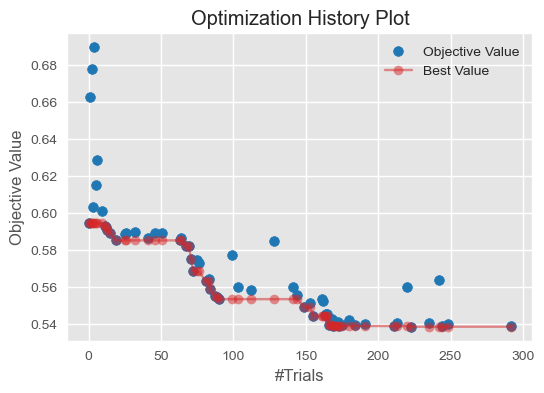

In [8]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study);

In [11]:
study.best_params

{'n_estimators': 500,
 'learning_rate': 0.29734997673606356,
 'max_depth': 11,
 'num_leaves': 11,
 'min_data_in_leaf': 200,
 'min_child_samples': 98,
 'lambda_l1': 0.9037886944882865,
 'lambda_l2': 0.011906183063897397,
 'min_gain_to_split': 0.007551036778260303,
 'feature_fraction': 0.9658507086246584,
 'bagging_fraction': 0.8476232920140797,
 'bagging_freq': 7,
 'colsample_bytree': 0.3}

# Performance du modèle

In [5]:
# Séparation de l'ensemble X_train en 2 sous-ensembles

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.33, random_state=101)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((206032, 56), (101479, 56), (206032, 1), (101479, 1))

In [7]:
model_LGBM = LGBMClassifier(objective="binary",
                            class_weight="balanced",
                            verbose=-1,
                            boosting_type="gbdt",
                            n_estimators=500,
                            learning_rate=0.29734997673606356,
                            max_depth=11,
                            num_leaves=11,
                            min_data_in_leaf=200,
                            min_child_samples=98,
                            lambda_l1=0.9037886944882865,
                            lambda_l2=0.011906183063897397,
                            min_gain_to_split=0.007551036778260303,
                            feature_fraction=0.9658507086246584,
                            bagging_fraction=0.8476232920140797,
                            bagging_freq=7,
                            colsample_bytree=0.3,
                            random_state=101,
                            n_jobs=-2,)

model_LGBM_fit = model_LGBM.fit(X_train, y_train)

# Make predictions
y_pred_lgbm = model_LGBM_fit.predict(X_valid)

y_pred_lgbm_proba = model_LGBM_fit.predict_proba(X_valid)

[LightGBM] [Warning] feature_fraction is set=0.9658507086246584, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9658507086246584
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007551036778260303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007551036778260303
[LightGBM] [Warning] bagging_fraction is set=0.8476232920140797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8476232920140797
[LightGBM] [Warning] lambda_l1 is set=0.9037886944882865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9037886944882865
[LightGBM] [Warning] lambda_l2 is set=0.011906183063897397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011906183063897397
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


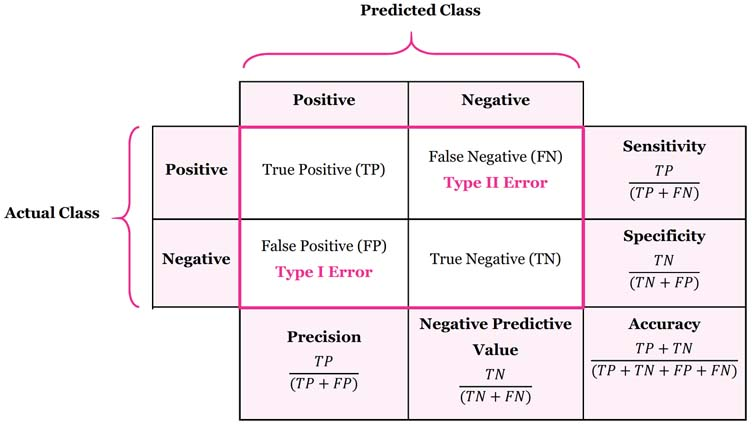

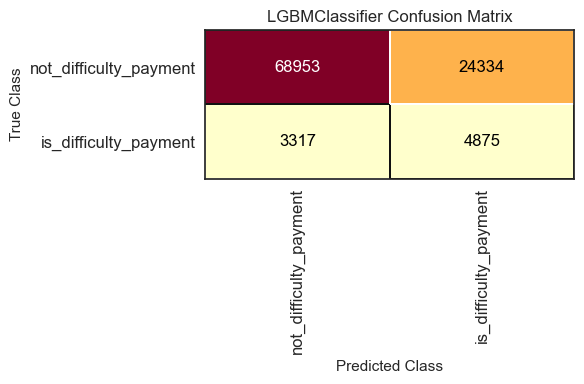

<AxesSubplot: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [9]:
from yellowbrick.classifier import ConfusionMatrix

classes = ['not_difficulty_payment', 'is_difficulty_payment']

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 4))

cm = ConfusionMatrix(model_LGBM_fit, classes=classes)

cm.fit(X_train, y_train)        # Fit the visualizer and the model
cm.score(X_valid, y_valid)        # Evaluate the model on the test data
cm.show()

In [10]:
print(classification_report(y_valid, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83     93287
           1       0.17      0.60      0.26      8192

    accuracy                           0.73    101479
   macro avg       0.56      0.67      0.55    101479
weighted avg       0.89      0.73      0.79    101479



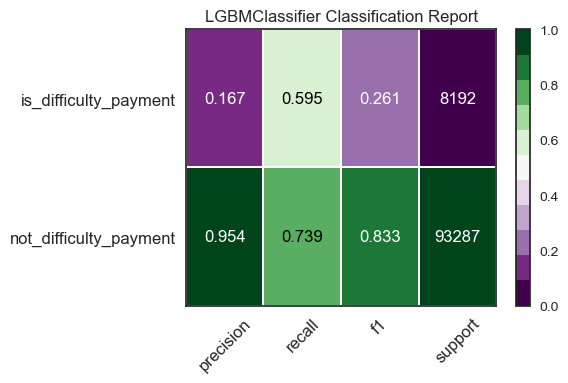

<AxesSubplot: title={'center': 'LGBMClassifier Classification Report'}>

In [11]:
# Identifying classes. The classes variable will be useful when using Yellowbrick's visualizers
classes = ['not_difficulty_payment', 'is_difficulty_payment']

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ClassificationReport(model_LGBM_fit, classes=classes, support=True, cmap='PRGn')

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_valid, y_valid)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [12]:
print(f"Train Accuracy : {accuracy_score(y_train, model_LGBM_fit.predict(X_train)):.2%}")
print(f"Test Accuracy : {accuracy_score(y_valid, y_pred_lgbm):.2%}")

Train Accuracy : 75.76%
Test Accuracy : 72.75%


In [13]:
print(f"Train Precision : {precision_score(y_train, model_LGBM_fit.predict(X_train)):.2%}")
print(f"Test Precision : {precision_score(y_valid, y_pred_lgbm):.2%}")

Train Precision : 22.30%
Test Precision : 16.69%


In [14]:
print(f"Train Recall : {recall_score(y_train, model_LGBM_fit.predict(X_train)):.2%}")
print(f"Test Recall : {recall_score(y_valid, y_pred_lgbm):.2%}")

Train Recall : 80.60%
Test Recall : 59.51%


In [15]:
print(f"Train f1_score : {f1_score(y_train, model_LGBM_fit.predict(X_train)):.2%}")
print(f"Test f1_score : {f1_score(y_valid, y_pred_lgbm):.2%}")

Train f1_score : 34.94%
Test f1_score : 26.07%


In [16]:
print(f"Train f2_score : {fbeta_score(y_train, model_LGBM_fit.predict(X_train), beta=2):.2%}")
print(f"Test f2_score : {fbeta_score(y_valid, y_pred_lgbm, beta=2):.2%}")

Train f2_score : 52.93%
Test f2_score : 39.33%


In [17]:
print(f"Train ROC-AUC : {roc_auc_score(y_train, model_LGBM_fit.predict(X_train)):.2%}")
print(f"Test ROC-AUC : {roc_auc_score(y_valid, y_pred_lgbm):.2%}")

Train ROC-AUC : 77.97%
Test ROC-AUC : 66.71%


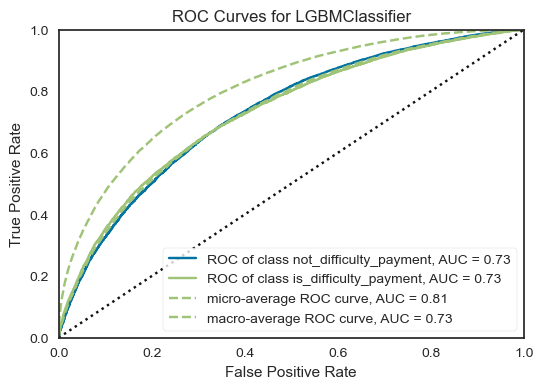

<AxesSubplot: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [18]:
from yellowbrick.classifier import ROCAUC

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 4))

vis_rocauc = ROCAUC(model_LGBM_fit, classes=classes, random_state=101)

vis_rocauc.fit(X_train, y_train)        
vis_rocauc.score(X_valid, y_valid)
vis_rocauc.show()   

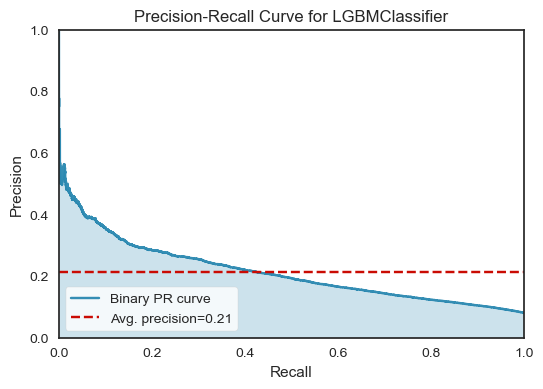

<AxesSubplot: title={'center': 'Precision-Recall Curve for LGBMClassifier'}, xlabel='Recall', ylabel='Precision'>

In [19]:
from yellowbrick.classifier import PrecisionRecallCurve

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 4))

vis_prc = PrecisionRecallCurve(model_LGBM_fit, random_state=101)

vis_prc.fit(X_train, y_train)        
vis_prc.score(X_valid, y_valid)     
vis_prc.show()  

In [21]:
from sklearn.metrics import precision_recall_curve, roc_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.title("Precision/Recall Tradeoff")
    

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

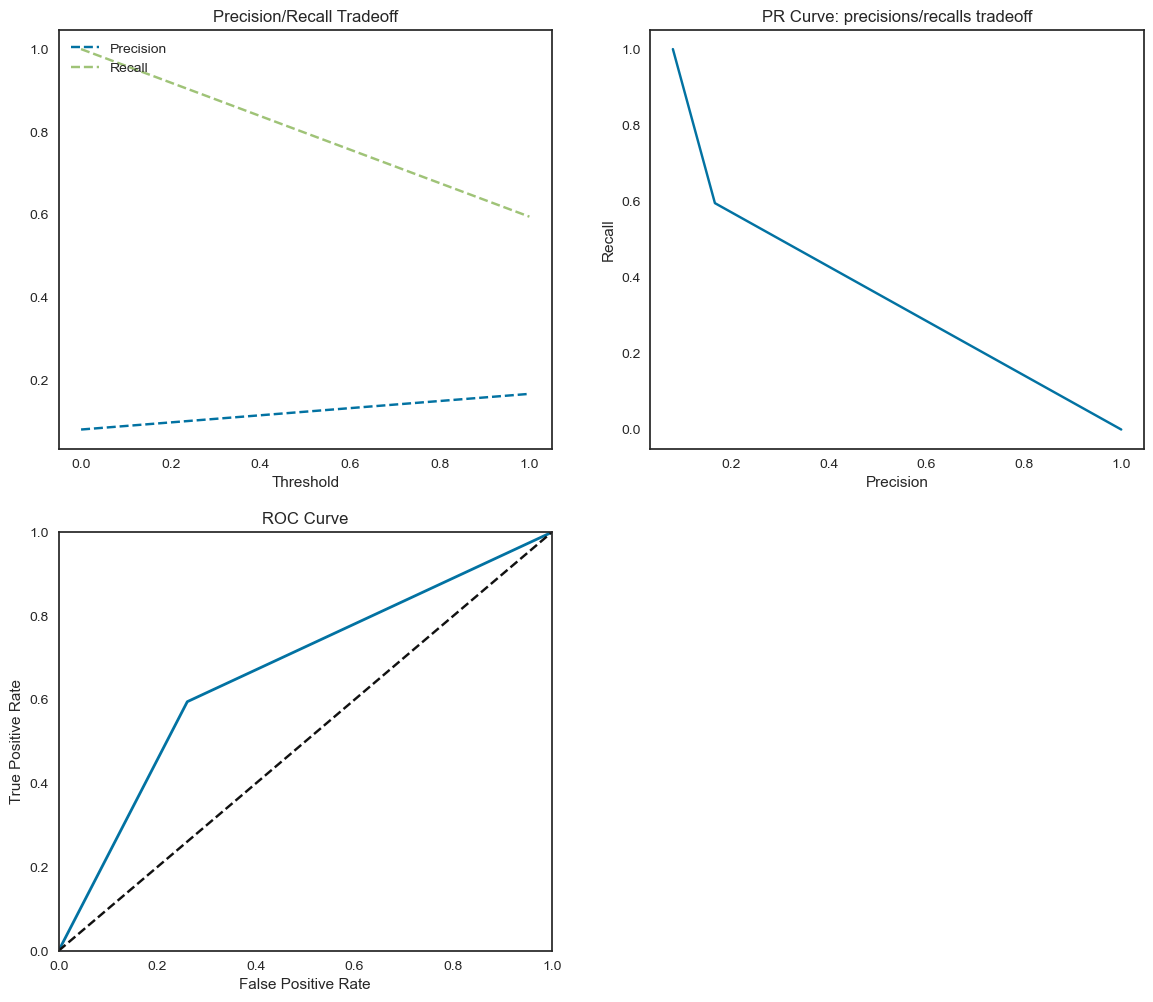

In [22]:
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred_lgbm)
plt.figure(figsize=(14, 25))
plt.subplot(4, 2, 1)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.subplot(4, 2, 2)
plt.plot(precisions, recalls)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR Curve: precisions/recalls tradeoff");

plt.subplot(4, 2, 3)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_lgbm)
plot_roc_curve(fpr, tpr)